In [1]:
import gym

import gym_rf

# from gym_rf.envs.rf_env import MIMO
from scipy.constants import *
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot

import matplotlib as mpl 

## agg backend is used to create plot as a .png file
#mpl.use('agg')

import matplotlib.pyplot as plt

from matplotlib import cm

import scipy.io

import random

from ast import literal_eval

import time

import pandas as pd

In [2]:
def play_one_episode(model, eps, gamma, alpha):
    observation = model.env.reset()
    done = False
    iters = 0
    totalreward = 0

    while (not done and iters < 201):
        action = model.sample_action(observation, eps)
        # print("action:{0}".format(action))
        prev_observation = observation

        observation, reward, done, info = model.env.step(action)
        #print("reward: {0}".format(reward))
        model.Q[prev_observation, action] += alpha*(reward + gamma*np.max(model.Q[observation, :])- model.Q[prev_observation, action])
        #if(model.env.observation_values[observation][0] == 58):
        #    print("final state is reached")
            
        totalreward += reward

        iters += 1
        if ((iters + 1) % 100) == 0:
            print("Play one episode: {0} iters are done".format(iters + 1))

    goal_count = 0
    if (iters < 201):
        goal_count =1
    return totalreward, goal_count




In [3]:
def Custom_Space_Mapping(actions):

    parameter_count = len(actions.keys())
    parameter_list = []
    for key in actions.keys():
        par_range = actions[key]#[actions.keys[i]]
        parameter_list.append(list(range(par_range[0],par_range[1]+1,par_range[2])))


    #creates a list of all possible tuples from given lists of action values
    action_val_tuples = [list(x) for x in np.array(np.meshgrid(*parameter_list)).T.reshape(-1,len(parameter_list))]
    action_key_list = list(np.arange(len(action_val_tuples)))

    action_values = dict(zip(action_key_list,action_val_tuples))
    #print("action_values: {0}".format(action_values))
    return action_values


In [4]:
class Model:
    def __init__(self, env):
        self.env = env
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        #for i in range(self.env.observation_space.n):
        #    for j in range(self.env.action_space.n):
        #        self.Q[i,j] = -1*alpha

    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.Q[s,:])


In [5]:
if __name__ == '__main__':
    env = gym.make('rf-v0')
    #xrange=100
    #xangle=40
    #env.set_distance(xrange,xangle)
    alpha = 0.3
    model = Model(env)
    gamma = 0.99
    
    Xrange = np.arange(100,1001,100)
    Xangle = np.arange(0,41,20)
    distance_pairs =[(xr,xa) for xr in Xrange for xa in Xangle]
    #mimo_ep_interval = 50
    
    #This worked for Xrange(100,1001,100) Xangle(0,1,0)
    #mimo_model_goals = [48,42, 38, 36, 34, 32, 31, 30, 29, 28] #[50,43,39,36,34,33,32,30,30,30]
    #mimo_ep_interval=1200#[1000,800,800,800,800,800,800,800,600,600]
    
    mimo_model_goals = [48,46,47,42,40,41, 38, 36,38,36, 34, 35,34,32,33,32,30,32, 31, 29,30,30,28,29, 29,27,28, 28,26,27]
    mimo_ep_interval=1000#[600,800,800,800,800,800,800,800,600,600]
    
    
    N = mimo_ep_interval*len(mimo_model_goals)#+400#np.sum(mimo_ep_intervals)
    
    rwd_list=[]
    rwds=[]
    eps=np.zeros(N)
    goal_count = np.zeros(len(mimo_model_goals))
    count=0
    for ndx in range(len(mimo_model_goals)):
        #if ndx == 0:
        #    mimo_ep_interval = 1200
        #elif ndx >=8:
        #    mimo_ep_interval = 600
        #else:
        #    mimo_ep_interval = 800
        #change mimo model
        #if n % mimo_ep_interval == 0:
        #    ndx = int(n/mimo_ep_interval)
        model.env.set_distance(distance_pairs[ndx][0], distance_pairs[ndx][1], mimo_model_goals[ndx])    
        print("Env distance set to ({0}, {1}), Index: {2}".format(distance_pairs[ndx][0], distance_pairs[ndx][1], ndx))
        
        for n in range(mimo_ep_interval): #mimo_ep_intervals[ndx]
            
            #0.2*(1-count/N)
            eps[count] = 0.2*(1-count/N)#0.2*(1-(n % (mimo_ep_intervals[ndx]+1))/(mimo_ep_intervals[ndx]+1))#0.75*(1-n/N)#1.0 / np.sqrt(n + 1)
            #state = env.reset()
            print("n: {0}, ndx: {1}, mimo_ep_interval: {2}".format(n, ndx, mimo_ep_interval))
            rwd, goal_flag = play_one_episode(model, eps[count], gamma, alpha)
            count+=1
            goal_count[ndx] += goal_flag
            rwd_list.append(rwd)
        #if (len(rwd_list) % mimo_ep_interval) == 0:
        rwds.append(np.mean(rwd_list[-mimo_ep_interval: ]))
    #print(rwd_list)
    print("Score over time: {0}".format(sum(rwd_list) /N))

    print("Final Q-table: {0}".format(model.Q))
    
    Actions = model.env.Actions
    states = model.env.Observations
    action_values = Custom_Space_Mapping(Actions)
    state_values = Custom_Space_Mapping(states)
    rev_state_values = dict((v[0], k) for k, v in state_values.items())
    rev_action_values = dict((str(v), k) for k,v in action_values.items())
    
    file = open('Q_data.txt', 'w')
    for i in range(model.Q.shape[0]):
        for j in range(model.Q.shape[1]):
            file.write(str(model.Q[i,j])+ '\t'+ str([i,j]) + '\t' + str(state_values[i])  +'\t'+ str(action_values[j]) +'\n')
    file.close()

    print("No. of times target has been reached: {0}".format(goal_count))

Env distance set to (100, 0), Index: 0
n: 0, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 1, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 2, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 3, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 4, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 5, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 6, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 7, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Play one episode: 200 iters are done
n: 8, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 14
n: 86, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 16
n: 87, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 4
n: 88, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 89, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 90, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 91, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 9
n: 92, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 4
n: 93, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 94, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 95, ndx: 0, mimo_ep_int

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 23
n: 168, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 4
n: 169, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 170, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 171, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 8
n: 172, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 15
n: 173, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 8
n: 174, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 21
n: 175, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 5
n: 176, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 30
n: 177, ndx: 0,

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 69
n: 249, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 15
n: 250, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 251, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 11
n: 252, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 4
n: 253, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 5
n: 254, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 255, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 256, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 7
n: 257, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 17
n: 258, ndx: 0,

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 29
n: 331, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 4
n: 332, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 21
n: 333, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 334, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 335, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 5
n: 336, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 8
n: 337, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 338, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 339, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 340, ndx: 0, m

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 28
n: 414, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 415, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 12
n: 416, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 36
n: 417, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 23
n: 418, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 11
n: 419, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 40
n: 420, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 4
n: 421, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 29
n: 422, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 22
n: 423, ndx

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 97
n: 495, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 44
n: 496, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 43
n: 497, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 11
n: 498, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 51
n: 499, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 31
n: 500, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 46
n: 501, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 12
n: 502, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 88
n: 503, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 85
n: 504, n

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 12
n: 579, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 24
n: 580, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 13
n: 581, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 4
n: 582, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 9
n: 583, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 26
n: 584, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 26
n: 585, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 48
n: 586, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 10
n: 587, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 37
n: 588, ndx

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 56
n: 661, ndx: 0, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 104
n: 662, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 17
n: 663, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 40
n: 664, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 61
n: 665, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 73
n: 666, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 7
n: 667, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 46
n: 668, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 57
n: 669, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Tak

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 45
n: 743, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 22
n: 744, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 745, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 11
n: 746, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 747, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 42
n: 748, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 21
n: 749, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 20
n: 750, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 49
n: 751, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 752, ndx:

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 5
n: 825, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 26
n: 826, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 8
n: 827, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 15
n: 828, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 17
n: 829, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 830, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 7
n: 831, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 19
n: 832, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 12
n: 833, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 834, ndx: 0

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 33
n: 906, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 9
n: 907, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 17
n: 908, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
n: 909, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 9
n: 910, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 35
n: 911, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 12
n: 912, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 913, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 39
n: 914, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 915, ndx: 0

Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 6
n: 994, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 5
n: 995, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 5
n: 996, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 997, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 998, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 3
n: 999, ndx: 0, mimo_ep_interval: 1000
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 22
Env distance set to (100, 20), Index: 1
n: 0, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 16
n: 1, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 5
n: 2, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0,

Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 5
n: 80, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 7
n: 81, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 3
n: 82, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 83, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 5
n: 84, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 8
n: 85, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 86, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 16
n: 87, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 8
n: 88, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 7
n: 89, ndx: 1, mimo_ep_int

Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 23
n: 177, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 178, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 179, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 180, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 181, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 14
n: 182, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 5
n: 183, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 184, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 185, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 6
n: 186, ndx: 1, m

Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 10
n: 260, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 261, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 3
n: 262, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 8
n: 263, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 1
n: 264, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 8
n: 265, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 9
n: 266, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 9
n: 267, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 268, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 3
n: 269, ndx: 1, mi

Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 10
n: 355, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 6
n: 356, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 1
n: 357, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 16
n: 358, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 359, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 2
n: 360, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 18
n: 361, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 8
n: 362, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 11
n: 363, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 21
n: 364, ndx:

Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 13
n: 439, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 440, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 441, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 14
n: 442, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 6
n: 443, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 15
n: 444, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 2
n: 445, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 31
n: 446, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 7
n: 447, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 4
n: 448, ndx: 

Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 24
n: 522, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 4
n: 523, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 9
n: 524, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 6
n: 525, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 526, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 17
n: 527, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 19
n: 528, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 7
n: 529, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 4
n: 530, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 1
n: 531, ndx: 1

Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 7
n: 615, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 13
n: 616, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 7
n: 617, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 13
n: 618, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 619, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 620, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 8
n: 621, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 5
n: 622, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 3
n: 623, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 8
n: 624, ndx: 1, 

Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 12
n: 695, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 6
n: 696, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 697, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 698, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 12
n: 699, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 8
n: 700, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 5
n: 701, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 3
n: 702, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 9
n: 703, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 12
n: 704, ndx: 1,

Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 5
n: 775, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 13
n: 776, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 10
n: 777, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 10
n: 778, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 2
n: 779, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 7
n: 780, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 20
n: 781, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 4
n: 782, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 7
n: 783, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 23
n: 784, ndx

Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 14
n: 860, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 861, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 7
n: 862, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 863, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 2
n: 864, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 6
n: 865, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 2
n: 866, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 7
n: 867, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 16
n: 868, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 8
n: 869, ndx: 1

Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 2
n: 945, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 946, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 6
n: 947, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 948, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, -5, 3, 3], steps: 5
n: 949, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 950, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 2
n: 951, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 7
n: 952, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [0, 0, 3, 3], steps: 5
n: 953, ndx: 1, mimo_ep_interval: 1000
Reached Final state: 46, Actions Taken: [5, 0, 3, 3], steps: 3
n: 954, ndx: 1, m

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 27
n: 39, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 9
n: 40, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 41, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 3
n: 42, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 43, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 5
n: 44, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 45, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 1
n: 46, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 13
n: 47, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 7
n: 48, ndx: 2, mimo_ep_int

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 12
n: 126, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 58
n: 127, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 15
n: 128, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 129, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 130, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 12
n: 131, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 11
n: 132, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 133, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 9
n: 134, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 11
n: 135, ndx: 

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 15
n: 218, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 219, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 6
n: 220, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 8
n: 221, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 3
n: 222, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 223, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 7
n: 224, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 10
n: 225, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 6
n: 226, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 8
n: 227, ndx: 2, m

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 17
n: 306, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 1
n: 307, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 6
n: 308, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 309, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 310, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 8
n: 311, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 3
n: 312, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 3
n: 313, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 5
n: 314, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 315, ndx: 2, mi

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 37
n: 394, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 9
n: 395, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 396, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 10
n: 397, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 398, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 11
n: 399, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 400, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 32
n: 401, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 6
n: 402, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 1
n: 403, ndx: 2,

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 9
n: 481, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 7
n: 482, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 483, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 8
n: 484, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 21
n: 485, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 6
n: 486, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 10
n: 487, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 13
n: 488, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 489, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 490, ndx: 2, 

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 8
n: 581, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [-5, 5, 3, 3], steps: 14
n: 582, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 583, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 15
n: 584, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [-5, 5, 3, 3], steps: 4
n: 585, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 586, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 587, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 12
n: 588, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 589, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [-5, 5, 3, 3], steps: 10
n: 590, ndx:

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 676, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 677, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 3
n: 678, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 5
n: 679, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 20
n: 680, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 17
n: 681, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 22
n: 682, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 683, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 1
n: 684, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 685, ndx: 2, 

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 9
n: 763, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 764, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 5
n: 765, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 1
n: 766, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 5
n: 767, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 22
n: 768, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 769, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 7
n: 770, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [-5, 5, 3, 3], steps: 2
n: 771, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 5
n: 772, ndx: 2, m

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 859, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 860, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [-5, 5, 3, 3], steps: 5
n: 861, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 862, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 863, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 26
n: 864, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 5
n: 865, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 866, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [-5, 5, 3, 3], steps: 9
n: 867, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 6
n: 868, ndx: 2, 

Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 942, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 943, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 944, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 1
n: 945, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 4
n: 946, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [-5, 5, 3, 3], steps: 3
n: 947, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 6
n: 948, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 8
n: 949, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 3
n: 950, ndx: 2, mimo_ep_interval: 1000
Reached Final state: 47, Actions Taken: [0, 0, 3, 3], steps: 2
n: 951, ndx: 2, mi

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 14
n: 27, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 28, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 29, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 30, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 31, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 10
n: 32, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 13
n: 33, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 34, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 35, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 36, ndx: 3, mimo_ep_in

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 17
n: 110, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 111, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 112, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 10
n: 113, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 114, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 115, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 116, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 10
n: 117, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 23
n: 118, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 119, ndx: 3,

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 14
n: 204, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 205, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 8
n: 206, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 207, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 1
n: 208, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 209, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 14
n: 210, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 211, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 13
n: 212, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 213, ndx: 3, 

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 17
n: 296, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 297, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 298, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 16
n: 299, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 300, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 301, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 8
n: 302, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 303, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 304, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 305, ndx: 3, m

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 393, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 394, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 395, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 396, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 397, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 398, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 7
n: 399, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 8
n: 400, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 401, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 16
n: 402, ndx: 3, mi

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 16
n: 485, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 486, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 10
n: 487, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 11
n: 488, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 489, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 490, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 491, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 492, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 1
n: 493, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 494, ndx: 3, 

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 20
n: 570, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 571, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 572, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 7
n: 573, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 574, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 12
n: 575, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 21
n: 576, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 577, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 578, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 579, ndx: 3, 

n: 662, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 7
n: 663, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 664, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 665, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 666, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 667, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 1
n: 668, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 8
n: 669, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 670, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 671, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0,

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 748, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 7
n: 749, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 750, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 12
n: 751, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 752, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 753, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 7
n: 754, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 7
n: 755, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 1
n: 756, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 757, ndx: 3, mi

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 854, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 855, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 1
n: 856, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 5
n: 857, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 1
n: 858, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 11
n: 859, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 860, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 861, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 862, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 863, ndx: 3, mi

Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 12
n: 937, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 9
n: 938, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 939, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 940, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 941, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 8
n: 942, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 6
n: 943, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 3
n: 944, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 2
n: 945, ndx: 3, mimo_ep_interval: 1000
Reached Final state: 42, Actions Taken: [0, 0, 3, 3], steps: 4
n: 946, ndx: 3, mi

Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 3
n: 42, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 43, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 6
n: 44, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 45, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 46, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 47, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 48, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 49, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 50, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 51, ndx: 4, mimo_ep_

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 8
n: 143, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 144, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 145, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 6
n: 146, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 147, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 148, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 7
n: 149, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 19
n: 150, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 1
n: 151, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 152, ndx: 4, mi

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 6
n: 228, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 229, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 5
n: 230, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 9
n: 231, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 6
n: 232, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 11
n: 233, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 234, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 8
n: 235, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 5
n: 236, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 237, ndx: 4

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 325, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 20
n: 326, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 10
n: 327, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 328, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 5
n: 329, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 9
n: 330, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 331, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 6
n: 332, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 333, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 10
n: 334, ndx: 4,

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 9
n: 413, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 414, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 415, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 1
n: 416, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 417, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 418, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 419, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 1
n: 420, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 7
n: 421, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 5
n: 422, ndx: 4, 

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 493, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 494, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 11
n: 495, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 496, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 7
n: 497, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 498, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 1
n: 499, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 500, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 501, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 3
n: 502, ndx: 4, 

Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 11
n: 594, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 595, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 8
n: 596, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 4
n: 597, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 598, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 599, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 5
n: 600, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 1
n: 601, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 4
n: 602, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 603, ndx:

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 6
n: 675, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 676, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 677, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 7
n: 678, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 16
n: 679, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 16
n: 680, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 681, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 682, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 1
n: 683, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 684, ndx: 

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 7
n: 759, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 6
n: 760, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 761, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 762, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 763, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 1
n: 764, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 765, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 1
n: 766, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 767, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 768, ndx: 4, m

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 6
n: 846, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 5
n: 847, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 848, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 849, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 850, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 6
n: 851, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 852, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 853, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 6
n: 854, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 8
n: 855, ndx: 4, m

Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 937, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 938, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 939, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 2
n: 940, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 2
n: 941, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 3
n: 942, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, 0, 3, 3], steps: 4
n: 943, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 1
n: 944, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 14
n: 945, ndx: 4, mimo_ep_interval: 1000
Reached Final state: 40, Actions Taken: [0, -5, 3, 3], steps: 8
n: 946, ndx: 4

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 28, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 29, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 30, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 31, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 12
n: 32, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 33, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 34, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 35, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 7
n: 36, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 8
n: 37, ndx: 5, mimo_ep_inte

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 14
n: 119, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 120, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 121, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 122, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 123, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 124, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 125, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 126, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 127, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 11
n: 128, ndx: 5, m

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 7
n: 204, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 205, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 206, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 207, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 208, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 209, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 210, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 211, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 212, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 7
n: 213, ndx: 5, mim

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 291, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 292, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 293, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 294, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 295, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 296, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 297, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 298, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 299, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 300, ndx: 5, mim

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 14
n: 377, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 378, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 379, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 380, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 381, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 1
n: 382, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 383, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 384, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 9
n: 385, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 386, ndx: 5, mi

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 477, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 478, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 9
n: 479, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 480, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 481, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 8
n: 482, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 12
n: 483, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 484, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 485, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 486, ndx: 5, mi

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 19
n: 562, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 1
n: 563, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 564, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 1
n: 565, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 566, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 567, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 8
n: 568, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 22
n: 569, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 1
n: 570, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 1
n: 571, ndx: 5, m

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 650, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 651, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 7
n: 652, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 653, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 8
n: 654, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 655, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 10
n: 656, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [-5, 0, 3, 3], steps: 17
n: 657, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 658, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [-5, 0, 3, 3], steps: 13
n: 659, ndx: 5

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 758, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 7
n: 759, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 760, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 761, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 762, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 763, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 764, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 765, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 766, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 767, ndx: 5, mim

n: 861, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 862, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 863, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 864, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 865, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 10
n: 866, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 867, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 3
n: 868, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 869, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 870, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0

Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 11
n: 960, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 4
n: 961, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 962, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 2
n: 963, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 7
n: 964, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 5, 3, 3], steps: 2
n: 965, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 6
n: 966, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 1
n: 967, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 5, 3, 3], steps: 1
n: 968, ndx: 5, mimo_ep_interval: 1000
Reached Final state: 41, Actions Taken: [0, 0, 3, 3], steps: 5
n: 969, ndx: 5, mi

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 50, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 51, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 52, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 53, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 54, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 55, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 56, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 57, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 58, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 59, ndx: 6, mimo_ep_inter

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 146, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 11
n: 147, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 148, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 149, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 150, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 151, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 152, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 17
n: 153, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 154, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 155, ndx: 6, m

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 20
n: 227, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 228, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 229, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 230, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 231, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 28
n: 232, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 16
n: 233, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 12
n: 234, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 235, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 24
n: 236, ndx: 

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 14
n: 313, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 29
n: 314, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 315, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 20
n: 316, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 36
n: 317, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 318, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 59
n: 319, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 16
n: 320, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 12
n: 321, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 322, ndx:

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 397, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 398, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 399, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 37
n: 400, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 401, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 402, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 403, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 12
n: 404, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 405, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 406, ndx: 6, m

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 29
n: 486, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 487, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 488, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 489, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 490, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 491, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 492, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 12
n: 493, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 494, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 495, ndx: 6, m

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 14
n: 571, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 572, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 573, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 28
n: 574, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 575, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 576, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 577, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 578, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 579, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 16
n: 580, ndx: 6, 

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 19
n: 655, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 30
n: 656, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 657, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 21
n: 658, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 659, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 44
n: 660, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 661, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 662, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 663, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 664, ndx: 6,

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 749, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 750, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 751, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 18
n: 752, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 753, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 754, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 755, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 756, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 757, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 32
n: 758, ndx: 6, 

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 47
n: 831, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 832, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 833, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 834, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 41
n: 835, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 14
n: 836, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 837, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 20
n: 838, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 30
n: 839, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 840, ndx: 6

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 912, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 913, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 17
n: 914, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 915, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 12
n: 916, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 917, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 918, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 10
n: 919, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 920, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 921, ndx: 6, 

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 18
n: 992, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 993, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 994, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 995, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 18
n: 996, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 997, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 998, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 999, ndx: 6, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
Env distance set to (300, 20), Index: 7
n: 0, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 9
n: 76, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 77, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 16
n: 78, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 79, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 80, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 8
n: 81, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 6
n: 82, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 83, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 7
n: 84, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 11
n: 85, ndx: 7, mimo_ep

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 14
n: 182, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 183, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 1
n: 184, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 185, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 186, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 17
n: 187, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 188, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 189, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 20
n: 190, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 1
n: 191, ndx: 7

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 47
n: 276, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 277, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 278, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 7
n: 279, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 280, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 281, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 282, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 6
n: 283, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 6
n: 284, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 285, ndx: 7, m

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 26
n: 361, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 362, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 4
n: 363, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 364, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 365, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 366, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 4
n: 367, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 26
n: 368, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 369, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 370, ndx: 7

Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 445, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 15
n: 446, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 447, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 448, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 9
n: 449, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 450, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 451, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 452, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 453, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 454, ndx: 7

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 11
n: 544, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 545, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 546, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 3
n: 547, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 548, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 549, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 550, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 7
n: 551, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 552, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 3
n: 553, ndx: 7,

Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 4
n: 642, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 643, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 8
n: 644, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 6
n: 645, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 3
n: 646, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 647, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 648, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 6
n: 649, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 6
n: 650, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 651, ndx: 7

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 10
n: 740, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 741, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 3
n: 742, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 12
n: 743, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 744, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 745, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 1
n: 746, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 747, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 748, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 749, ndx

Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 30
n: 820, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 821, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 822, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 823, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 824, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 7
n: 825, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 826, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 827, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 828, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 1
n: 829, ndx:

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 15
n: 930, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 931, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 1
n: 932, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 933, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 934, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 5
n: 935, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 936, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 937, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, -5, 3, 3], steps: 2
n: 938, ndx: 7, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 939, ndx: 7

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 41
n: 18, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 11
n: 19, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 22
n: 20, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 47
n: 21, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 22, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 23, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 24, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 19
n: 25, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 17
n: 26, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 27, ndx: 8, mimo_ep

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 24
n: 102, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 15
n: 103, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 104, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 50
n: 105, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 10
n: 106, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 107, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 108, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 109, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 110, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 111, ndx: 8

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 34
n: 185, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 45
n: 186, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 25
n: 187, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 188, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 189, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 22
n: 190, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 191, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 192, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 193, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 194, ndx: 8,

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 267, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 268, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 269, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 14
n: 270, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 271, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 24
n: 272, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 44
n: 273, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 11
n: 274, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 275, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 276, ndx: 8

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 39
n: 348, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 14
n: 349, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 22
n: 350, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 34
n: 351, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 352, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 61
n: 353, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 71
n: 354, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 355, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 11
n: 356, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 12
n: 357, nd

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 64
n: 432, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 433, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 20
n: 434, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 435, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 10
n: 436, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 437, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 438, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 439, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 440, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 25
n: 441, ndx: 8,

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 47
n: 526, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 527, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 528, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 21
n: 529, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 530, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 531, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 532, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 533, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 534, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 70
n: 535, ndx: 8, 

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 15
n: 615, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 23
n: 616, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 617, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 24
n: 618, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 619, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 620, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 15
n: 621, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 622, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 623, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 10
n: 624, ndx: 

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 25
n: 706, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 16
n: 707, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 708, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 709, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 20
n: 710, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 9
n: 711, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 712, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 713, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 10
n: 714, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 715, ndx: 8,

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 801, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 802, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 3
n: 803, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 804, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 805, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 8
n: 806, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 807, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 808, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 809, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 810, ndx: 8, mim

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 26
n: 897, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 21
n: 898, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 52
n: 899, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 13
n: 900, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 901, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 902, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 29
n: 903, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 5
n: 904, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 19
n: 905, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 50
n: 906, ndx:

Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 37
n: 985, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 12
n: 986, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 2
n: 987, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 17
n: 988, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 989, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 7
n: 990, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 6
n: 991, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 14
n: 992, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 4
n: 993, ndx: 8, mimo_ep_interval: 1000
Reached Final state: 38, Actions Taken: [0, 0, 3, 3], steps: 1
n: 994, ndx: 8,

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 21
n: 66, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 14
n: 67, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 71
n: 68, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 33
n: 69, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 70, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 12
n: 71, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 72, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 73, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 9
n: 74, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 9
n: 75, ndx: 9, mimo_ep_

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 55
n: 156, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 157, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 39
n: 158, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 77
n: 159, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 10
n: 160, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 161, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 24
n: 162, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 13
n: 163, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 164, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 21
n: 165, ndx:

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 14
n: 245, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 45
n: 246, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 247, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 32
n: 248, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 249, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 250, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 251, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 26
n: 252, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 10
n: 253, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 254, ndx: 9

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 63
n: 329, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 330, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 331, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 332, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 37
n: 333, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 12
n: 334, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 23
n: 335, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 32
n: 336, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 12
n: 337, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 23
n: 338, ndx:

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 7
n: 415, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 416, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 417, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 418, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 419, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 6
n: 420, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 41
n: 421, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 17
n: 422, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 14
n: 423, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 9
n: 424, ndx: 9, 

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 501, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 502, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 503, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 11
n: 504, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 505, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 20
n: 506, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 7
n: 507, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 13
n: 508, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 509, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 510, ndx: 9, 

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 46
n: 586, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 587, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 588, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 61
n: 589, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 53
n: 590, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 19
n: 591, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 7
n: 592, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 30
n: 593, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 24
n: 594, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 595, ndx: 

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 83
n: 666, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 667, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 668, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 669, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 25
n: 670, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 6
n: 671, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 12
n: 672, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 20
n: 673, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 24
n: 674, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 675, ndx: 9

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 45
n: 746, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 4
n: 747, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 38
n: 748, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 749, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 750, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 58
n: 751, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 44
n: 752, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 753, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 15
n: 754, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 755, ndx: 9

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 833, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 13
n: 834, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 835, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 8
n: 836, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 11
n: 837, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 16
n: 838, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 13
n: 839, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 5
n: 840, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 23
n: 841, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 842, ndx: 9

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 46
n: 916, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 25
n: 917, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 12
n: 918, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 2
n: 919, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 27
n: 920, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 97
n: 921, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 12
n: 922, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 16
n: 923, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 1
n: 924, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 10
n: 925, ndx

Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
n: 998, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 6
n: 999, ndx: 9, mimo_ep_interval: 1000
Reached Final state: 36, Actions Taken: [0, 0, 3, 3], steps: 3
Env distance set to (400, 20), Index: 10
n: 0, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 15
n: 1, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 2, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 3, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 6
n: 4, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 3
n: 5, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 6, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5,

Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 7
n: 86, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 11
n: 87, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 12
n: 88, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 89, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 90, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 12
n: 91, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 5
n: 92, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 93, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 94, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 7
n: 95, ndx

Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 48
n: 167, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 6
n: 168, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 1
n: 169, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 8
n: 170, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 10
n: 171, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 4
n: 172, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 9
n: 173, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 7
n: 174, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 175, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 18


Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 10
n: 259, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 260, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 7
n: 261, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 262, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 263, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 18
n: 264, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 18
n: 265, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 266, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 267, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 3


Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 345, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 10
n: 346, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 347, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 16
n: 348, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 5
n: 349, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 10
n: 350, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 10
n: 351, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 8
n: 352, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 1
n: 353, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 6
n

Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 11
n: 441, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 1
n: 442, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 5
n: 443, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 3
n: 444, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 5
n: 445, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 4
n: 446, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 24
n: 447, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 4
n: 448, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 449, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 6

Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 4
n: 529, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 3
n: 530, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 531, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 4
n: 532, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 2
n: 533, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 1
n: 534, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 5
n: 535, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 536, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 2
n: 537, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 4
n:

Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 11
n: 612, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 14
n: 613, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 614, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 3
n: 615, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 6
n: 616, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 9
n: 617, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 618, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 619, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 8
n: 620, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 6


Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 7
n: 698, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 4
n: 699, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 700, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 701, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 3
n: 702, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 7
n: 703, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 704, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 705, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 706, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 7

Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 13
n: 778, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 16
n: 779, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 780, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 4
n: 781, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 10
n: 782, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 25
n: 783, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 784, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 785, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 786, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 7

Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 10
n: 860, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 5
n: 861, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 862, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 2
n: 863, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 5
n: 864, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 865, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 866, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 867, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 868, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 869

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 5
n: 948, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 6
n: 949, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 4
n: 950, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 11
n: 951, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 952, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 953, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 3
n: 954, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [5, -5, 3, 3], steps: 4
n: 955, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, -5, 3, 3], steps: 14
n: 956, ndx: 10, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 6
n: 27, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 18
n: 28, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 29, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 15
n: 30, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 2
n: 31, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 11
n: 32, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 9
n: 33, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 6
n: 34, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 4
n: 35, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 8
n: 36, ndx: 11, 

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 56
n: 115, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 9
n: 116, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 5
n: 117, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 9
n: 118, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 12
n: 119, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 4
n: 120, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 15
n: 121, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 24
n: 122, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 123, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 11
n: 12

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 14
n: 200, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 10
n: 201, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 17
n: 202, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 10
n: 203, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 16
n: 204, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 6
n: 205, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 8
n: 206, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 20
n: 207, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 13
n: 208, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 26
n: 286, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 4
n: 287, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 32
n: 288, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 24
n: 289, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 3
n: 290, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 8
n: 291, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 5
n: 292, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 11
n: 293, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 16
n: 294, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 8
n: 29

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 33
n: 373, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 44
n: 374, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 15
n: 375, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 7
n: 376, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 11
n: 377, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 12
n: 378, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 2
n: 379, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 380, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 3
n: 381, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 38

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 45
n: 457, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 74
n: 458, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 3
n: 459, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 3
n: 460, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 22
n: 461, ndx: 11, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 100
n: 462, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 4
n: 463, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 464, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 29
n: 465, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actio

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 19
n: 538, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 19
n: 539, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 17
n: 540, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 541, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 8
n: 542, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 3
n: 543, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 544, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 42
n: 545, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 33
n: 546, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 6
n: 54

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 49
n: 618, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 33
n: 619, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 7
n: 620, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 6
n: 621, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 39
n: 622, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 11
n: 623, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 11
n: 624, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 36
n: 625, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 31
n: 626, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 7
n: 

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 19
n: 699, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 10
n: 700, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 7
n: 701, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 36
n: 702, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 18
n: 703, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 7
n: 704, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 21
n: 705, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 5
n: 706, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 10
n: 707, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 5
n: 7

Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 7
n: 786, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 5
n: 787, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 9
n: 788, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 42
n: 789, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 8
n: 790, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 17
n: 791, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 17
n: 792, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 8
n: 793, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 17
n: 794, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 75
n: 79

Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 75
n: 867, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 55
n: 868, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 48
n: 869, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 10
n: 870, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 4
n: 871, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 2
n: 872, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 22
n: 873, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 2
n: 874, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 78
n: 875, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 28


Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 5
n: 959, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 1
n: 960, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 6
n: 961, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 13
n: 962, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 6
n: 963, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 1
n: 964, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 6
n: 965, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [-5, 0, 3, 3], steps: 4
n: 966, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 23
n: 967, ndx: 11, mimo_ep_interval: 1000
Reached Final state: 35, Actions Taken: [0, 0, 3, 3], steps: 17
n:

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 26
n: 45, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 5
n: 46, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 31
n: 47, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 26
n: 48, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 23
n: 49, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 29
n: 50, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 51, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 52, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 53, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 10
n: 54, ndx: 1

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 40
n: 125, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 41
n: 126, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 127, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 17
n: 128, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 129, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 130, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 9
n: 131, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 132, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 8
n: 133, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 134,

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 23
n: 216, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 39
n: 217, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 218, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 219, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 220, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 14
n: 221, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 10
n: 222, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 223, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 40
n: 224, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 38
n: 2

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 55
n: 301, ndx: 12, mimo_ep_interval: 1000
Play one episode: 100 iters are done
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 147
n: 302, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 26
n: 303, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 23
n: 304, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 17
n: 305, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 306, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 307, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 23
n: 308, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 9
n: 309, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Acti

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 34
n: 380, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 381, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 382, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 54
n: 383, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 35
n: 384, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 51
n: 385, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 386, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 27
n: 387, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 59
n: 388, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 3

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 11
n: 469, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 470, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 16
n: 471, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 26
n: 472, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 11
n: 473, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 10
n: 474, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 14
n: 475, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 22
n: 476, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 22
n: 477, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 10
n

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 553, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 11
n: 554, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 555, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 8
n: 556, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 557, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 11
n: 558, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 14
n: 559, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 560, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 561, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 5
n: 562,

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 12
n: 632, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 633, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 17
n: 634, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 16
n: 635, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 13
n: 636, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 637, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 638, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 639, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 640, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 641

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 33
n: 713, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 15
n: 714, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 715, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 716, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 11
n: 717, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 17
n: 718, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 719, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 720, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 27
n: 721, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 72

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 19
n: 801, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 802, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 803, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 11
n: 804, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 5
n: 805, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 806, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 26
n: 807, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 808, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 31
n: 809, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 810

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 7
n: 890, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 4
n: 891, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 2
n: 892, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 893, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 9
n: 894, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 5
n: 895, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 10
n: 896, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 16
n: 897, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 898, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 14
n: 899,

Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 41
n: 974, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 975, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 976, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 977, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 6
n: 978, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 1
n: 979, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 980, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 16
n: 981, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 13
n: 982, ndx: 12, mimo_ep_interval: 1000
Reached Final state: 34, Actions Taken: [0, 0, 3, 3], steps: 3
n: 983,

Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 5
n: 58, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 10
n: 59, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 3
n: 60, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 61, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 62, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 63, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 64, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 65, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 66, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 67, ndx: 13, 

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 162, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 163, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 164, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 5
n: 165, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 166, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 167, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 6
n: 168, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 11
n: 169, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 170, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 17

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 254, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 255, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 256, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 257, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 15
n: 258, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 259, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 260, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 8
n: 261, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 262, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 263,

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 336, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 337, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 338, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 14
n: 339, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 340, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 341, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 342, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 13
n: 343, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 344, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 34

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 417, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 418, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 11
n: 419, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 3
n: 420, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 421, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 3
n: 422, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 423, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 424, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 425, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 42

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 518, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 519, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 3
n: 520, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 521, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 1
n: 522, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 523, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 524, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 525, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 526, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 52

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 608, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 609, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 610, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 611, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 612, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 613, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 17
n: 614, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 615, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 10
n: 616, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 20
n: 617

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 688, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 689, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 3
n: 690, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 691, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 16
n: 692, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 10
n: 693, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 694, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 3
n: 695, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 696, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 13
n: 

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 22
n: 775, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 13
n: 776, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 777, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 778, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 4
n: 779, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 780, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 781, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 782, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 783, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 784

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 857, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 858, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 859, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 860, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 861, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 862, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 863, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 864, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 865, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 866, n

Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 19
n: 940, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 941, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 942, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 943, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 944, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 945, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 946, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, -5, 3, 3], steps: 2
n: 947, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 948, ndx: 13, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 949

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 14
n: 20, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 21, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 22, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 23, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 24, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 25, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 31
n: 26, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 27, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 28, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 29, ndx: 14, m

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 18
n: 106, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 107, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 108, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 109, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 110, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 111, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 17
n: 112, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 113, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 9
n: 114, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 115, 

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 188, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 189, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 190, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 22
n: 191, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 192, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 193, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 194, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 195, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 196, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 9
n: 197, n

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 279, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 280, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 8
n: 281, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 282, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 5
n: 283, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 5
n: 284, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 285, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 11
n: 286, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 5
n: 287, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 288, n

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 362, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 363, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 5
n: 364, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 365, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 366, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 5
n: 367, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 368, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 8
n: 369, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 370, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 371, nd

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 448, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 449, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 9
n: 450, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 451, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 452, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 10
n: 453, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 454, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 455, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 10
n: 456, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 457, 

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 544, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 12
n: 545, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 12
n: 546, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 547, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 548, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 549, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 8
n: 550, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 551, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 552, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 553, 

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 28
n: 640, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 641, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 642, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 643, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 644, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 645, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 646, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 8
n: 647, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 648, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 12
n: 649, 

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 32
n: 731, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 19
n: 732, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 733, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 734, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 735, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 10
n: 736, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 13
n: 737, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 13
n: 738, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 13
n: 739, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [-5, 0, 3, 3], steps: 2
n: 

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 8
n: 822, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 823, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 824, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 825, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 826, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 827, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 828, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 829, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 3
n: 830, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
n: 831, nd

Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 917, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 4
n: 918, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [-5, 0, 3, 3], steps: 2
n: 919, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 920, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 5
n: 921, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 922, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 6
n: 923, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 2
n: 924, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [-5, 0, 3, 3], steps: 4
n: 925, ndx: 14, mimo_ep_interval: 1000
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 7
n: 926, 

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 9, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 10, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 11, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 12, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 16
n: 13, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 14, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 11
n: 15, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 16, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 17, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 18, ndx: 15, mi

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 95, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 96, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 97, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 98, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 99, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 16
n: 100, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 101, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 102, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 103, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 104, ndx: 1

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 200, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 201, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 202, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 203, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 204, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 205, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 206, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 22
n: 207, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 208, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 209, n

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 281, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 282, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 283, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 284, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 285, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 286, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 287, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 288, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 289, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 290, nd

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 388, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 389, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 390, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 391, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 392, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 393, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 394, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 395, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 396, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 397, nd

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 488, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 13
n: 489, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 490, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 491, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 492, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 493, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 494, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 495, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 496, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 20
n: 497, 

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 576, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 577, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 578, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 579, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 580, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 581, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 582, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 583, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 584, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 585, n

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 675, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 676, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 677, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 678, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 679, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 680, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 681, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 682, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 683, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 684, nd

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 759, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 760, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 761, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 762, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 763, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 764, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 765, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 766, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 767, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 768, nd

n: 843, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 844, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 845, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 846, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 847, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 848, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 849, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 850, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 851, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 852, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions 

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 13
n: 931, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 932, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 933, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 934, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 935, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 936, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 937, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 938, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 939, ndx: 15, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 940, n

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 16, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 17, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 18, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 19, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 20, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 21, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 22, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 23, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 24, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 25, ndx: 16, mim

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 16
n: 102, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 103, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 104, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 105, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 106, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 107, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 108, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 109, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 110, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 111, n

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 185, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 186, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 187, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 188, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 189, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 190, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 191, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 192, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 193, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 10
n: 194, n

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 10
n: 284, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 285, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 286, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 287, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 288, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 289, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 10
n: 290, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 291, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 292, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 293, 

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 386, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 387, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 10
n: 388, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 389, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 390, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 391, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 12
n: 392, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 393, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 394, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 395, 

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 10
n: 466, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 467, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 468, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 469, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 470, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 471, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 472, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 473, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 22
n: 474, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 475, 

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 16
n: 565, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 566, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 9
n: 567, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 568, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 17
n: 569, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 570, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 12
n: 571, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 572, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 573, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 9
n: 574,

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 20
n: 661, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 662, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 663, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 664, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 665, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 23
n: 666, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 12
n: 667, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 668, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 669, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 670,

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 764, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 765, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 766, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 767, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 768, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 769, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 770, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 771, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 772, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 773, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 17
n: 850, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 851, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 852, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 853, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 854, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 855, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 856, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 857, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 858, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 859, n

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 947, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 948, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 9
n: 949, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 13
n: 950, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 951, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 952, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 953, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 954, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 955, ndx: 16, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 956, n

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 42, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 43, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 44, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 45, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 46, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 47, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 48, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 49, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 50, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 51, ndx: 17, mi

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 11
n: 125, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 126, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 127, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 128, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 129, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 130, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 131, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 10
n: 132, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 133, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 10
n: 134,

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 210, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 211, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 212, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 213, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 214, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 215, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 216, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 217, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 218, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 219, nd

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 13
n: 293, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 294, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 295, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 296, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 297, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 298, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 15
n: 299, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 300, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 301, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 302, 

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 387, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 388, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 389, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 390, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 391, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 392, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 393, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 394, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 395, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 396, n

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 14
n: 476, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 477, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 478, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 479, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 11
n: 480, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 481, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 482, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 483, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 17
n: 484, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 485,

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 575, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 16
n: 576, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 577, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 578, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 579, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 580, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 581, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 582, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 583, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 584, n

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 666, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 667, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 668, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 669, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 670, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 671, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 672, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 673, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 674, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 8
n: 675, nd

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 746, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 747, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 748, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 749, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 750, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 751, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 752, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 753, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 754, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 5
n: 755, nd

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 835, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 836, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 837, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 838, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 1
n: 839, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 9
n: 840, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 7
n: 841, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 842, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 6
n: 843, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 844, n

Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 16
n: 922, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 923, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 924, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 12
n: 925, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 3
n: 926, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 927, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 928, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 929, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 4
n: 930, ndx: 17, mimo_ep_interval: 1000
Reached Final state: 32, Actions Taken: [0, 0, 3, 3], steps: 2
n: 931, 

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 16
n: 13, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 9
n: 14, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 15, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 29
n: 16, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 17, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 18, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 7
n: 19, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 20, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 17
n: 21, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 22, ndx: 18, 

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 18
n: 100, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 101, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 16
n: 102, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 103, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 104, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 105, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 106, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 11
n: 107, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 17
n: 108, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 109

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 14
n: 192, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 9
n: 193, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 194, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 5
n: 195, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 196, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 9
n: 197, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 198, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 199, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 7
n: 200, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 201, n

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 290, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 6
n: 291, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 7
n: 292, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 293, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 294, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 295, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 296, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 297, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 298, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 6
n: 299, nd

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 393, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 394, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 5
n: 395, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 396, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 397, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 398, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 5
n: 399, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 400, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 401, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 402, nd

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 504, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 505, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 6
n: 506, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 507, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 508, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 509, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 510, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 511, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 512, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 513, nd

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 586, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 587, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 588, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 589, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 590, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 591, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 592, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 593, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 594, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 595, nd

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 670, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 671, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 672, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 673, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 674, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 675, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 676, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 677, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 678, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 679, nd

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 755, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 756, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 757, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 758, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 759, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 760, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 761, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 762, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 763, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 764, nd

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 843, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 844, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 845, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 4
n: 846, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 847, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 5
n: 848, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 849, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 850, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 851, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 852, nd

Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 932, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 5
n: 933, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 3
n: 934, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 935, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 936, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 937, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 938, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 939, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 2
n: 940, ndx: 18, mimo_ep_interval: 1000
Reached Final state: 31, Actions Taken: [0, 0, 3, 3], steps: 1
n: 941, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 20, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 21, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 22, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 23, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 24, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 25, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 26, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 27, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 28, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 29, ndx: 19, mim

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 124, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 125, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 126, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 127, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 128, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 129, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 130, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 131, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 132, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 133, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 240, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 241, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 242, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 243, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 244, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 245, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 246, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 247, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 248, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 249, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 342, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 343, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 344, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 345, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 346, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 347, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 348, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 349, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 14
n: 350, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 351, n

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 435, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 436, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 9
n: 437, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 438, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 439, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 440, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 9
n: 441, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 442, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 443, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 23
n: 444, n

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 533, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 534, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 535, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 536, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 537, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 538, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 539, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 540, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 541, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 542, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 628, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 629, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 630, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 631, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 632, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 633, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 11
n: 634, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 635, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 636, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 637, n

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 11
n: 726, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, -5, 3, 3], steps: 8
n: 727, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 728, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 729, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 730, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 731, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 732, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 733, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 734, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 735, 

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 808, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 809, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 810, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 811, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 812, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 813, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 814, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 815, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 816, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 817, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 900, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 901, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 902, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 9
n: 903, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, -5, 3, 3], steps: 2
n: 904, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 905, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 906, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 907, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 908, ndx: 19, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 909, n

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 2, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 3, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 4, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 5, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 6, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 7, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 8, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 9, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 9
n: 10, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 11, ndx: 20, mimo_ep_int

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 10
n: 83, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 84, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 85, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 86, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 87, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 88, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 89, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 90, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 91, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 92, ndx: 20, mi

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 190, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 191, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 9
n: 192, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 193, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 194, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 195, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 196, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 15
n: 197, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 198, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 199, n

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 286, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 287, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 288, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 289, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 290, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 291, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 292, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 293, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 294, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 295, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 379, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 380, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 381, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 382, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 383, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 384, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 385, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 386, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 387, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 388, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 480, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 481, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 482, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 483, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 484, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 485, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 486, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 487, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 488, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 489, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 599, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 600, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 601, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 602, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 603, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 604, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 605, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 606, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 607, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 608, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 709, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 710, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 711, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 712, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 713, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 714, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 715, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 716, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 717, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 718, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 802, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 803, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 804, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 805, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 806, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 807, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 808, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 809, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 810, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 811, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 881, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 882, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 883, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 884, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 10
n: 885, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 886, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 13
n: 887, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 888, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 889, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 890, 

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 982, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 983, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 984, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 985, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 986, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 987, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 988, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 989, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 990, ndx: 20, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 991, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 66, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 67, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 68, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 69, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 8
n: 70, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 71, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 72, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 73, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 74, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 75, ndx: 21, mim

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 154, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 155, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 156, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 157, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 158, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 159, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 160, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 161, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 162, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 6
n: 163, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 235, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 236, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 237, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 238, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 239, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 240, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 241, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 29
n: 242, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 243, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 18
n: 244, 

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 332, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 333, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 334, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 11
n: 335, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 336, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 337, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 338, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 339, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 340, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 341, n

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 438, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 439, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 440, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 441, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 442, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 443, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 444, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 7
n: 445, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 446, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 447, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 542, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 543, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 544, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 545, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 546, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 547, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 548, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 549, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 550, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 551, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 629, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 630, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 631, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 632, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 633, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 634, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 635, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 636, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 637, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 638, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 719, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 720, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 721, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 722, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 723, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 724, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 725, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 726, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 727, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 728, nd

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 808, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 809, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 810, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 811, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 812, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 813, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 814, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 815, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 816, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 817, nd

n: 901, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 902, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 903, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 904, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 905, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 4
n: 906, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 907, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 5
n: 908, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 909, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 1
n: 910, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions 

Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 997, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 3
n: 998, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
n: 999, ndx: 21, mimo_ep_interval: 1000
Reached Final state: 30, Actions Taken: [0, 0, 3, 3], steps: 2
Env distance set to (800, 20), Index: 22
n: 0, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 7
n: 1, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 2, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 3, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 4, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 5, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 111, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 112, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 113, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 114, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 115, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 116, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 117, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 118, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 119, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 120, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 9
n: 216, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 217, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 218, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 219, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 8
n: 220, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 9
n: 221, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 222, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 223, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 224, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 225, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 9
n: 309, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 310, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 311, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 312, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 313, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 314, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 5
n: 315, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 5
n: 316, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 317, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 10
n: 318, n

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 416, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 417, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 418, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 419, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 420, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 421, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 422, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 423, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 6
n: 424, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 425, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 11
n: 514, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 515, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 516, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 517, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 11
n: 518, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 519, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 520, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 521, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 522, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 523, 

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 8
n: 613, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 614, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 615, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 616, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 617, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 618, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 13
n: 619, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 620, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 621, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 622, n

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 7
n: 710, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 711, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 712, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 713, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 714, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 8
n: 715, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 716, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 717, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 718, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 719, nd

n: 824, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 825, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 826, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 827, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 828, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 829, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 830, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 831, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 832, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 833, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions 

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 933, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 934, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 935, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 936, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 5
n: 937, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 938, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 939, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 940, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 941, ndx: 22, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 942, nd

n: 33, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 34, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 35, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 36, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 37, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 38, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 11
n: 39, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 40, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 41, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 42, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 124, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 125, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 126, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 127, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 128, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 129, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 10
n: 130, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 131, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 132, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 133, n

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 230, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 231, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 232, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 233, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 234, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 235, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 236, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 237, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 238, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 239, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 335, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 336, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 337, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 338, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 339, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 340, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 341, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 342, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 343, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 344, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 14
n: 437, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 438, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 11
n: 439, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 440, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 441, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 442, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 443, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 444, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 445, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 446, 

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 533, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 534, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 535, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 536, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 537, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 538, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 539, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 540, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 541, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 542, nd

n: 621, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 622, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 623, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 624, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 625, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 626, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 627, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 628, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 629, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 630, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions 

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 704, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 705, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 706, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 11
n: 707, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 708, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 709, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 710, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 711, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 712, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 713, n

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 805, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 806, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 807, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 808, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 809, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 810, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 811, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 812, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 813, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 814, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 915, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 916, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 917, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 918, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 919, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 920, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 921, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 922, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 923, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 924, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 9
n: 998, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 999, ndx: 23, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
Env distance set to (900, 0), Index: 24
n: 0, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 1, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 2, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 3, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 4, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 5, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 6, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 87, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 88, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 89, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 90, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 91, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 92, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 93, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 94, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 95, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 96, ndx: 24, mim

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 204, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 205, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 206, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 207, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 208, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 209, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 210, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 211, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 212, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 213, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 331, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 332, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 333, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 334, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 335, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 336, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 337, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 8
n: 338, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 339, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 340, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 410, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 411, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 412, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 413, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 414, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 415, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 11
n: 416, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 417, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 418, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 419, n

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 7
n: 493, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 494, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 495, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 496, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 497, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 498, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 499, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 500, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 501, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 502, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 586, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 587, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 588, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 589, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 590, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 591, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 592, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 593, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 594, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 595, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 668, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 669, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 670, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 671, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 672, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 673, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 674, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 675, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 676, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 677, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 748, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 749, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 750, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 751, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 752, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 753, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 754, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 755, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 756, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 757, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 5
n: 830, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 9
n: 831, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 3
n: 832, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 6
n: 833, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 834, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 835, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 836, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 837, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 838, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 839, nd

Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 921, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 922, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 923, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 924, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 925, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 926, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 4
n: 927, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 2
n: 928, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 1
n: 929, ndx: 24, mimo_ep_interval: 1000
Reached Final state: 29, Actions Taken: [0, 0, 3, 3], steps: 11
n: 930, n

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 15, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 16, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 17, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 18, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 19, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 20, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 21, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 22, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 23, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 24, ndx: 25, mim

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 109, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 110, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 111, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 112, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 113, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 114, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 115, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 116, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 117, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 118, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 189, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 190, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 191, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 192, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 193, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 194, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 195, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 196, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 197, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 198, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 283, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 284, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 285, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 6
n: 286, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 287, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 288, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 289, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 290, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 291, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 292, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 372, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 373, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 374, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 375, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 376, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 377, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 378, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 379, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 380, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 381, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 459, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 460, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 461, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 462, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 463, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 464, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 465, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 466, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 467, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 468, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 545, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 546, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 547, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 548, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 549, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 550, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 551, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 552, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 553, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 554, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 641, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 642, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 643, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 644, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 645, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 646, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 647, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 648, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 649, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 650, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 727, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 728, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 729, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 730, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 731, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 732, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 733, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 734, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 6
n: 735, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 736, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 855, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 856, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 8
n: 857, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 858, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 859, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 860, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 861, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 862, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 863, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 864, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 950, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 951, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 952, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 953, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 954, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 955, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 956, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 957, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 958, ndx: 25, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 959, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 43, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 44, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 45, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 46, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 47, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 48, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 5
n: 49, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 50, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 51, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 52, ndx: 26, mim

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 136, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 137, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 138, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 139, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 5
n: 140, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 141, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 142, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 143, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 144, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 145, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 237, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 238, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 239, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 240, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 241, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 242, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 243, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 244, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 245, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 246, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 344, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 345, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 346, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 347, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 348, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 349, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 350, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 351, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 352, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 353, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 443, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 444, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 445, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 446, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 447, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 448, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 449, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 450, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 451, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 452, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 544, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 545, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 546, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 547, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 548, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 549, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 550, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 551, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 552, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 553, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 626, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 627, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 628, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 629, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 630, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 631, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 632, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 633, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 634, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 635, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 709, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 710, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 711, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 712, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 713, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 714, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 715, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 716, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 717, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 718, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 823, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 824, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 825, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 826, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 827, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 828, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 829, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 830, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 831, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 832, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 926, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 927, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 928, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 929, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 930, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 931, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 932, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 933, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 934, ndx: 26, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 935, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 17, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 18, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 19, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 20, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 21, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 22, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 23, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 24, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 25, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 26, ndx: 27, mim

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 122, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 123, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 124, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 125, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 126, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 127, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 128, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 129, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 130, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 131, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 222, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 223, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 224, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 225, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 226, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 227, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 228, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 229, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 230, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 231, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 319, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 320, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 321, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 322, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 323, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 324, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 325, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 326, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 327, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 328, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 421, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 422, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 423, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 424, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 425, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 426, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 427, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 428, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 429, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 430, nd

n: 523, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 524, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 525, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 526, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 527, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 528, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 529, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 530, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 531, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 532, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions 

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 627, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 628, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 629, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 630, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 631, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 632, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 633, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 634, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 635, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 636, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 725, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 726, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 727, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 3
n: 728, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 729, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 730, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 4
n: 731, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 732, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 733, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 734, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 824, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 825, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 826, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 827, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 828, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 829, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 830, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 831, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 832, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 833, nd

Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 933, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 934, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 935, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 936, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 937, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 938, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 939, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 1
n: 940, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 941, ndx: 27, mimo_ep_interval: 1000
Reached Final state: 28, Actions Taken: [0, 0, 3, 3], steps: 2
n: 942, nd

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 37, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 38, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 39, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 40, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 41, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 4
n: 42, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 43, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 44, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 45, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 46, ndx: 28, mim

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 160, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 161, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 162, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 163, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 4
n: 164, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 165, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 166, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 167, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 168, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 169, nd

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 251, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 252, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 253, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 254, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 255, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 256, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 4
n: 257, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 258, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 259, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 4
n: 260, nd

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 371, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 372, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 373, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 374, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, -5, 3, 3], steps: 2
n: 375, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 376, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 377, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 378, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 379, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 380, n

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 473, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 4
n: 474, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 475, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, -5, 3, 3], steps: 2
n: 476, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 477, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 478, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 479, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 480, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 4
n: 481, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 8
n: 482, n

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 8
n: 556, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 557, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 4
n: 558, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 559, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 5
n: 560, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 561, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 562, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 6
n: 563, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 564, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 565, nd

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 651, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 652, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 653, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 654, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 655, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 656, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 657, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 658, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 659, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 660, nd

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 741, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 742, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, -5, 3, 3], steps: 2
n: 743, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 744, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, -5, 3, 3], steps: 2
n: 745, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 746, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 747, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 748, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 749, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 750, 

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 832, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 5
n: 833, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 834, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 835, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 836, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 837, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 838, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 839, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 840, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, -5, 3, 3], steps: 2
n: 841, n

Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 919, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 920, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 921, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 922, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 923, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 924, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 2
n: 925, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, -5, 3, 3], steps: 1
n: 926, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 3
n: 927, ndx: 28, mimo_ep_interval: 1000
Reached Final state: 26, Actions Taken: [0, 0, 3, 3], steps: 1
n: 928, n

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 10
n: 10, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 11, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 12, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 13, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 14, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 6
n: 15, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 16, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 6
n: 17, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 18, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 19, ndx: 29, mi

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 92, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 93, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 94, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 95, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 96, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 97, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 98, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 99, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 100, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 101, ndx: 29, m

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 191, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 192, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 193, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 194, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 195, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 196, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 197, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 198, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 199, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 6
n: 200, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 288, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 6
n: 289, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 290, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 291, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 292, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 293, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 294, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 295, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 296, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 297, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 371, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 372, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 373, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 374, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 375, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 376, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 377, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 8
n: 378, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 379, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 380, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 466, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 467, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 468, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 469, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 470, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 471, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 472, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 473, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 474, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 475, nd

n: 557, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 558, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 559, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 560, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 561, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 4
n: 562, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 563, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 564, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 565, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 566, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions 

n: 644, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 645, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 646, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 647, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 648, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 649, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 5
n: 650, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 651, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 652, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 653, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions 

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 736, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 737, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 738, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 739, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 740, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 741, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 742, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 743, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 744, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 745, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 823, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 824, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 825, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 826, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 827, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 828, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 829, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 830, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 831, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 832, nd

Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 931, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 932, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 933, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 8
n: 934, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 935, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 2
n: 936, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 937, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 1
n: 938, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 939, ndx: 29, mimo_ep_interval: 1000
Reached Final state: 27, Actions Taken: [0, 0, 3, 3], steps: 3
n: 940, nd

SNR state: [24], Q_value: 0.0
SNR state: [25], Q_value: 0.0
SNR state: [26], Q_value: 0.0
SNR state: [27], Q_value: 0.0
SNR state: [28], Q_value: 0.0
SNR state: [29], Q_value: 0.0
SNR state: [30], Q_value: 0.0
SNR state: [31], Q_value: 36.454309777526994
SNR state: [32], Q_value: 0.0
SNR state: [33], Q_value: 0.0
SNR state: [34], Q_value: 0.0
SNR state: [35], Q_value: 0.0
SNR state: [36], Q_value: 0.0
SNR state: [37], Q_value: 0.0
SNR state: [38], Q_value: 0.0
SNR state: [39], Q_value: 0.0
SNR state: [40], Q_value: 0.0
SNR state: [41], Q_value: 0.0
SNR state: [42], Q_value: 0.0
SNR state: [43], Q_value: 0.0
SNR state: [44], Q_value: 0.0
SNR state: [45], Q_value: 36.11442777237851
SNR state: [46], Q_value: 0.0
SNR state: [47], Q_value: 0.0
SNR state: [48], Q_value: 0.0
Average Cumulative Reward: -160.15901297924296


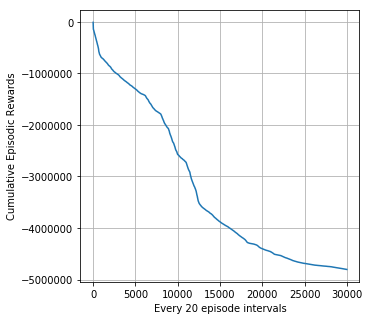

In [6]:
    
    temp_action=[0,0,3,3]
    action_state= rev_action_values[str(temp_action)]
    for i in range(54,79,1):
        print("SNR state: {0}, Q_value: {1}".format(state_values[i], model.Q[i, action_state]))
    fig = plt.figure(figsize=(5,5))#plt.figaspect(2.))
    
    
    #fig.suptitle('Q table learning plots')
    
    #First Graph - Episodic Rewards over the training time
    #ax = fig.add_subplot(4, 1, 1)
    print('Average Cumulative Reward: {0}'.format(np.array(rwds).mean()))
    #ax.plot(rwds)
    #ax.grid()
    #ax.set_ylabel('Episodic Rewards')
    plt.plot(np.cumsum(rwd_list))
    #plt.plot(rwds)
    plt.grid()
    plt.xlabel('Every 20 episode intervals')
    plt.ylabel('Cumulative Episodic Rewards')

    #print(rev_action_values)
    plt.show()
  

Action_values dimensions: 3969
State_values dimensions: 81
Q_values dimensions: (81, 3969)


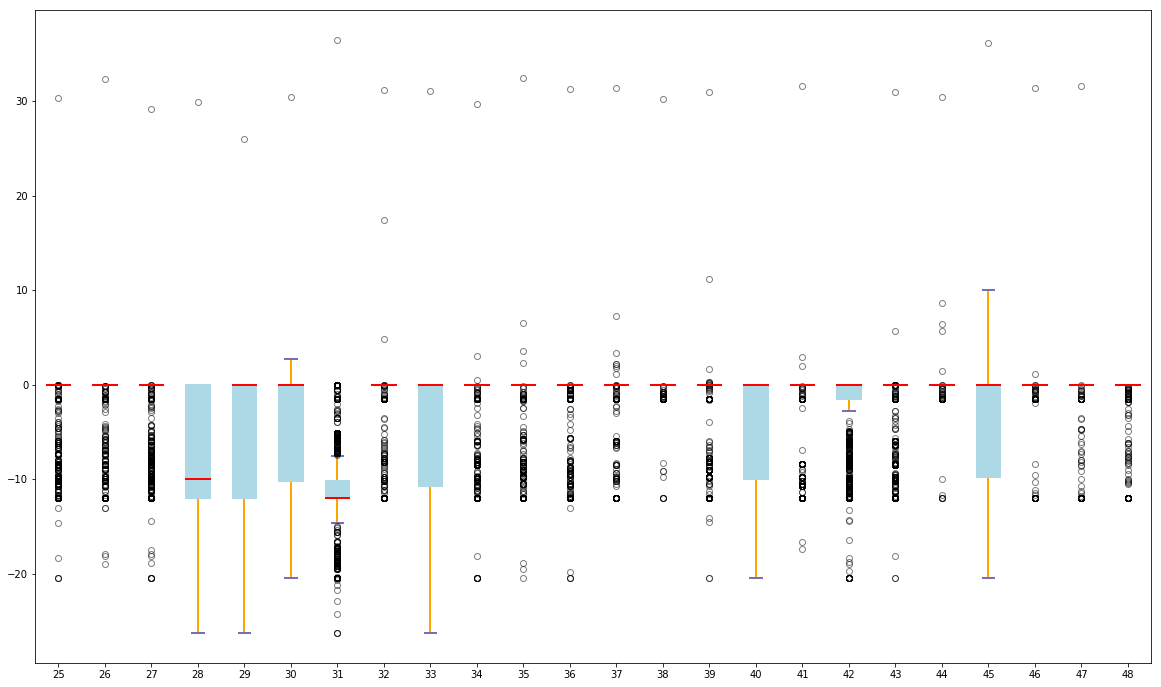

In [7]:
    #Second Graph 
    '''
        Plot the distribution of Q-values over states and actions
    '''
    '''
    action_values_list = action_values.keys()
    ax2 = fig.add_subplot(4, 1, 2)
    for n in range(model.Q.shape[0]):
        if np.max(model.Q[n, :]) > 0:
            ax2.plot(action_values_list, model.Q[n, :], label="n=%d" % (n,))
    ax2.grid()
    ax2.set_xlabel('actions')
    ax2.set_ylabel('Q values')
    '''
    fig = plt.figure(1, figsize=(20, 12))
    data_to_plot=[]
    labels=[]
    print("Action_values dimensions: {0}".format(len(action_values)))
    print("State_values dimensions: {0}".format(len(state_values)))
    print("Q_values dimensions: {0}".format(model.Q.shape))
    
  
    #Creating a Box plot
    for s in state_values.keys():
        if(s >54 and s < 79):
            data_to_plot.append(model.Q[s, :])
            labels.append(str(s-30))
    #ax2 = fig.add_subplot(111)
    bp = plt.boxplot(data_to_plot,  vert=True,  # vertical box alignment
                    patch_artist=True, labels=labels)  # fill with color)
    
    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='lightblue', linewidth=2)
        # change fill color
        #print(box)
        box.set_facecolor('lightblue' )
    
    
    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='orange', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#7570b3', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='red', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    # Save the figure
    #fig.savefig('fig1.png', bbox_inches='tight')
    plt.show()
    
    
    


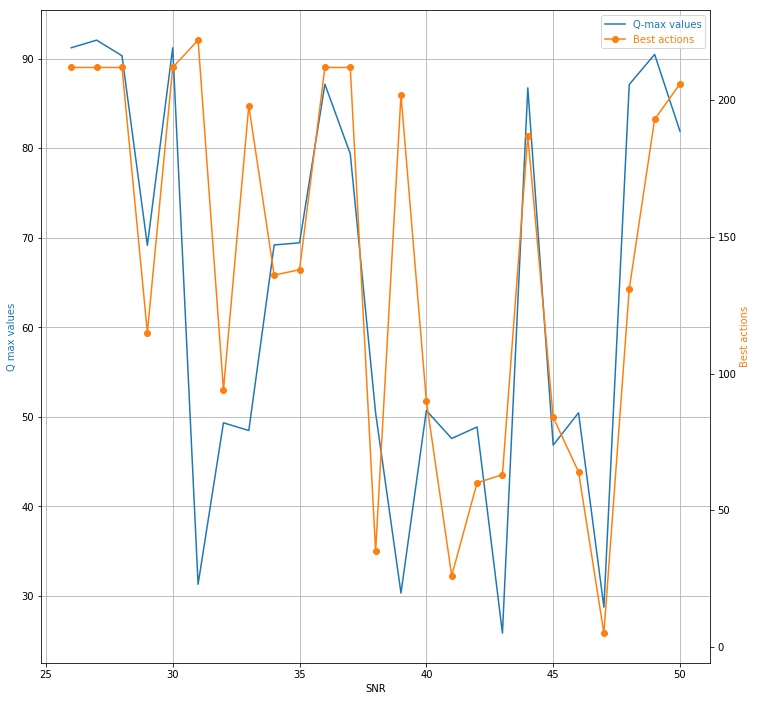

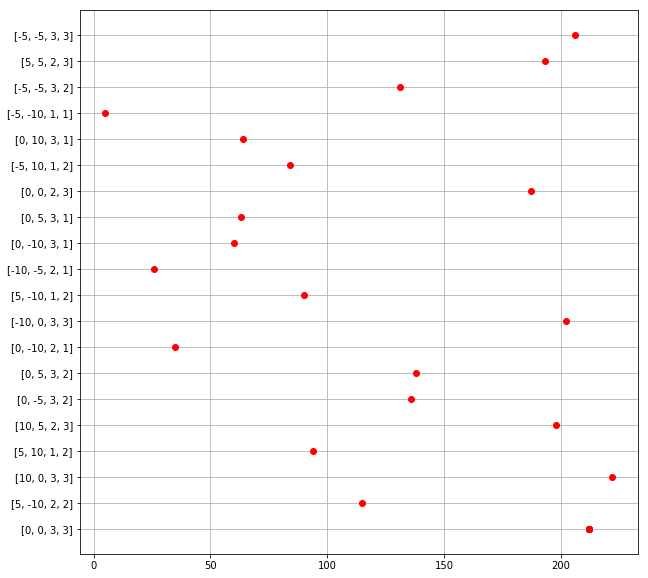

In [8]:
    #Plot max-Q values from each state and label it with its corresponding action
    max_Q_values = []
    best_action_values=[]
    snr=[]
    for s in state_values.keys():
        if s>55 and s<101:
            max_Q_values.append(np.max(model.Q[s, :]))
            best_action_values.append(np.argmax(model.Q[s, :]))
            snr.append(state_values[s])
    #print(str(action_values[best_action_values[0]]))
    #print(best_action_values)
    #fig = plt.figure(num="maxQ plot",figsize=(20, 12))
    #plt.plot(max_Q_values)
    #plt.plot(best_action_values)
    best_actions = [str(action_values[x]) for x in best_action_values]
    
    #plt.show()
    fig = plt.figure(num="maxQ plot",figsize=(12, 12))
    host = host_subplot(111, figure=fig)
    #host.set_aspect(1.)

    par = host.twinx()

    host.set_xlabel("SNR")
    host.set_ylabel("Q max values")
    par.set_ylabel("Best actions")

    p1, = host.plot(snr, max_Q_values, label="Q-max values")
    p2, = par.plot(snr, best_action_values, label="Best actions",marker='o')
    
    leg = plt.legend()

    host.yaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.yaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())
    
    plt.grid()
    
    fig2 = plt.figure(num="Action Mappings", figsize=(10,10))
    plt.plot(best_action_values, best_actions,'ro')
    plt.grid()
    plt.show()

initial SNR: 4, initial random action: (0, 0, 1, 1), goal_state: 33
Reached Final state: 33, Actions Taken: [0, 0, 3, 3], steps: 1
Previous Obs: 4, action: 3748, action_values: [0, 0, 3, 3], Observation: 33, done: True
[4, 33]
['[0, 0, 3, 3]']
Rate: 0.8163503964304597, RateOpt: 0.8165194350448949
SNR 30 best action: 2015, action_value: [5, 50, 2, 2], SNR 30 Q-value: 30.395788681197978


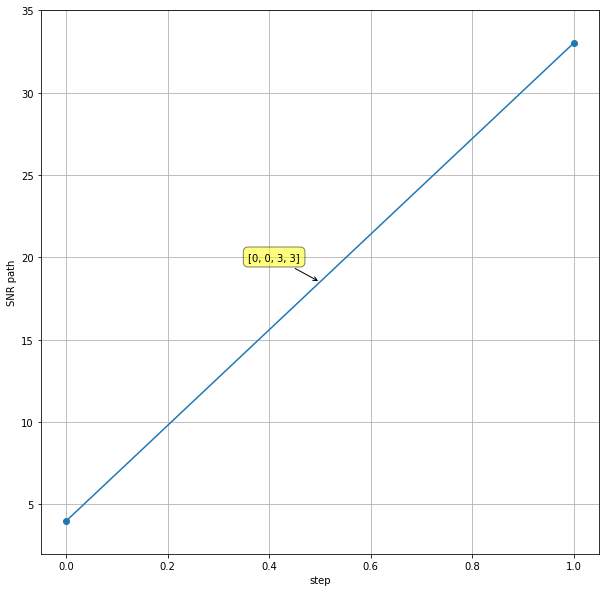

In [31]:
    fig = plt.figure(1, figsize=(10, 10))
    #This worked for Xrange(100,1001,100) Xangle(0,1,0)
    #test_mimo_model_goals = [48,42, 38, 36, 34, 32, 31, 30, 29, 28]
    test_mimo_model_goals = [48,46,47,42,40,41, 38, 36,38,36, 34, 35,34,32,33,32,30,32, 31, 29,30,30,28,29, 29,27,28, 28,26,27]
    
    #transmitter posX, posY -> calc SNR with random (RBS, TBS, 1)
    
    #New MIMO model
    Xrange = 500
    Xangle = 40
    RBS,TBS = (0,0)#random.sample(np.arange(-50,50,5).tolist(),2)
    #define the mimo model based on the new location defined in test case
    action_val = (RBS,TBS,1,1)
    mimo_goal_state = test_mimo_model_goals[14]#test_mimo_model_goals[14]
    observation, action_val = model.env.test_reset(Xrange, Xangle, action_val, mimo_goal_state)
    print("initial SNR: {0}, initial random action: {1}, goal_state: {2}".format(state_values[observation][0], action_val, mimo_goal_state))
    
    done = False
    count = 0

    SNR_path = [state_values[observation][0]]
    action_labels = []
    max_snr_state = rev_state_values[48]  # model.env.observation_space.n -1 #maximum state
    
    
    while ((observation < max_snr_state) and (count < 5)):
        predict = model.Q[observation] 
        #if count == 0:
        #    print("Snr state: {0}, best action num: {1}".format(state_values[observation][0], np.argmax(predict)))
        #    plt.plot(np.arange(len(predict)), predict)
        #    plt.show()
        #    break
            
        # print('Final predict values: {0} '.format(predict.argmax()))
        action = np.argmax(predict)
        previous_observation = observation
        observation, reward, done, info = model.env.step(action)     
        print(
            "Previous Obs: {0}, action: {1}, action_values: {2}, Observation: {3}, done: {4}".format(state_values[previous_observation][0],
                                                                                 action, action_values[action],state_values[observation][0], done))
       
        #print(goal_range)
        SNR_path.append(state_values[observation][0])
        action_labels.append(str(action_values[action]))
        
        if(state_values[observation][0] >= mimo_goal_state):                                                                           
            break
        
        count += 1
    print(SNR_path)
    print(action_labels)
    
    #Calculate data Rate
    Tf = 2 #in msec
    rate, rateOpt = model.env.get_Rate(count,Tf)
    print("Rate: {0}, RateOpt: {1}".format(rate, rateOpt))
    # print(np.max(SNR_path))
    max_snr_state = 0
    #for s in range(model.Q.shape[0]):
    #    print("SNR: {0}, max-Q-value: {1}, best_action: {2}, action_values: {3}".format(state_values[s], np.max(model.Q[s,:]), np.argmax(model.Q[s,:]), action_values[np.argmax(model.Q[s,:])]))

    # print(max_snr_state)
    goal_state = rev_state_values[30]
    # print(state_values)
    # print(rev_state_values)
    #print(model.Q.shape)
    #print(np.max(model.Q[goal_state, :]))#, np.max(model.Q[180]))
    print("SNR 30 best action: {0}, action_value: {1}, SNR 30 Q-value: {2}".format(np.argmax(model.Q[goal_state, :]),
                                                                                   action_values[np.argmax(
                                                                                       model.Q[goal_state, :])],
                                                                                   np.max(model.Q[goal_state, :])))
    # print("Max state learnt: {0}, action: {1}, action_value: {2}, Q-value: {4}".format(state_values[max_snr_state], np.argmax(model.Q[max_snr_state, :]), action_values[np.argmax(model.Q[max_snr_state, :])], np.max(model.Q[max_snr_state,:])))

    #ax3 = fig.add_subplot(4, 1, 4)
   
    
    plt.plot(np.arange(len(SNR_path)), SNR_path, marker='o')
    for i in range(len(SNR_path)-1):
        x,y = (2*i+1)/2, (SNR_path[i]+SNR_path[i+1])/2
        plt.annotate(action_labels[i],xy=(x, y), xytext=(-20, 20),textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.grid()
    plt.ylim(np.min(SNR_path)-2, np.max(SNR_path)+2)
    #ax3.set_xlabel('step')
    #ax3.set_ylabel('SNR path')
    plt.xlabel('step')
    plt.ylabel('SNR path')
    plt.show()
    

SNR initial state: 15, mimo_model_goal: 48
Goal range: [46 47 48 49]
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
SNR initial state: 18, mimo_model_goal: 48
Goal range: [46 47 48 49]
SNR initial state: 15, mimo_model_goal: 48
Goal range: [46 47 48 49]
Reached Final state: 48, Actions Taken: [0, 0, 3, 3], steps: 2
SNR initial state: 8, mimo_model_goal: 46
Goal range: [44 45 46 47]
SNR initial state: 9, mimo_model_goal: 46
Goal range: [44 45 46 47]
SNR initial state: 7, mimo_model_goal: 46
Goal range: [44 45 46 47]
SNR initial state: 6, mimo_model_goal: 47
Goal range: [45 46 47 48]
SNR initial state: 7, mimo_model_goal: 47
Goal range: [45 46 47 48]
SNR initial state: 9, mimo_model_goal: 47
Goal range: [45 46 47 48]
SNR initial state: 6, mimo_model_goal: 42
Goal range: [40 41 42 43]
SNR initial state: 0, mimo_model_goal: 42
Goal range: [40 41 42 43]
SNR initial state: 6, mimo_model_goal: 42
Goal range: [40 41 42 43]
SNR initial state: -1, mimo_model_goal: 40
Goal range: 

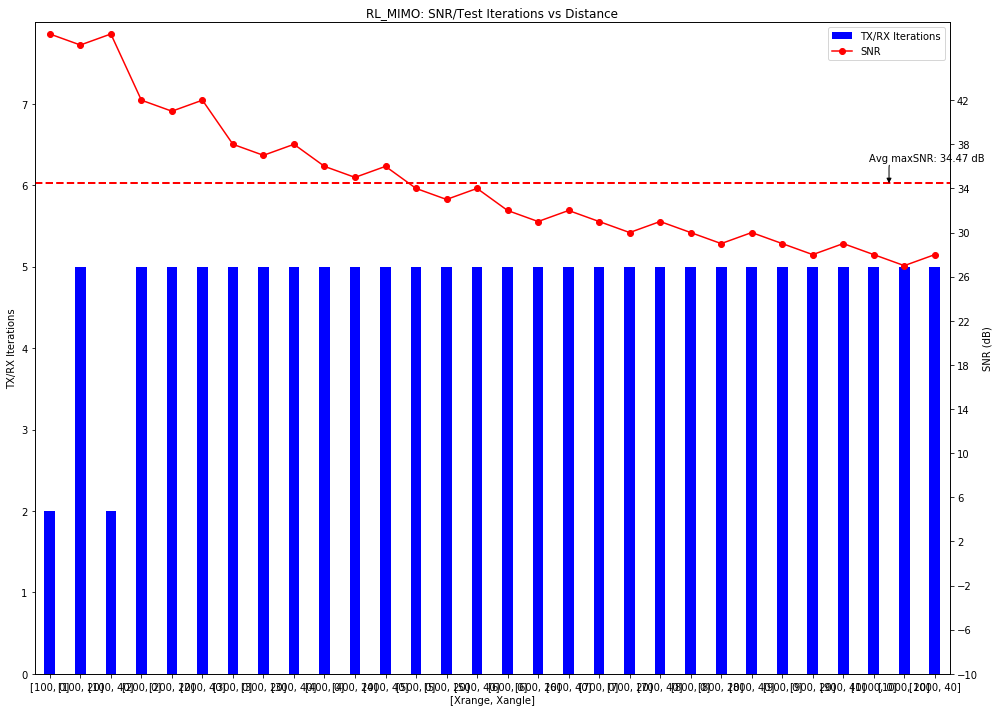

In [9]:
    total_maxSNR_values=[]
    total_dataRate_values=[]
    total_dataRateOpt_values=[]
    total_steps_count=[]
    
    for ndx in range(1):
        #Measuring Performance - CDF of steps vs Distance
        Xrange = np.arange(100,1001,100).tolist()
        Xangle = np.arange(0,41,20).tolist()
        steps_count = np.zeros([len(Xrange), len(Xangle)])
        Xaxis =[]
        maxSNR_labels=[]
        maxSNR_values=[]

        #Data Rate parameters
        Tf = 20
        dataRate= np.zeros([len(Xrange), len(Xangle)])
        dataRateOpt= np.zeros([len(Xrange), len(Xangle)])

        consumed_times=np.zeros([len(Xrange), len(Xangle)])
        for i in range(len(Xrange)):
            for j in range(len(Xangle)):
                then = time.time()
                RBS,TBS = random.sample(np.arange(-50,50,5).tolist(),2)
                action_val = (RBS,TBS,1,1)

                #define the mimo model based on the new location defined in test case
                observation, action_val = model.env.test_reset(Xrange[i], Xangle[j], action_val, test_mimo_model_goals[i])
                print("SNR initial state: {0}, mimo_model_goal: {1}".format(state_values[observation][0], test_mimo_model_goals[i]))
                #print("initial SNR: {0}, initial random action: {1}".format(state_values[observation][0], action_val))

                done = False
                count = 0

                SNR_path = [state_values[observation][0]]
                action_labels = []
                max_snr_state = rev_state_values[48] #mimo_model_goals[i]# # model.env.observation_space.n -1 #maximum state
                goal_range = np.arange(test_mimo_model_goals[i]-2, 2+test_mimo_model_goals[i])
                print("Goal range: {0}".format(goal_range))
                while ((observation < max_snr_state) and (count <5)):
                    predict = model.Q[observation] 
                    action = np.argmax(predict)
                    previous_observation = observation
                    observation, reward, done, info = model.env.step(action)     

                    #add to the SNR path
                    SNR_path.append(state_values[observation][0])
                    action_labels.append(str(action_values[action]))
                    count += 1
                    if(state_values[observation][0] >= test_mimo_model_goals[i]):
                    #if(state_values[observation][0] in goal_range):
                        break

                now=time.time()
                consumed_times[i,j] = (now-then)
                steps_count[i,j] = count

                #calculate data rate
                dataRate[i,j], dataRateOpt[i,j] = model.env.get_Rate(count, Tf)
                #print(opt_val, opt_val[0])
                #dataRateOpt[i,j] = opt_val[0][0]   

                maxSNR_labels.append(str(np.max(SNR_path)) + 'dB')
                maxSNR_values.append(np.max(SNR_path))
                Xaxis.append(str([Xrange[i],Xangle[j]]))
        total_maxSNR_values.append(maxSNR_values)
        total_dataRate_values.append(dataRate.ravel())
        total_dataRateOpt_values.append(dataRateOpt.ravel())
        total_steps_count.append(steps_count.ravel())
    
    #print(total_maxSNR_values)
    print(np.mean(total_maxSNR_values, axis=0))
    avg_maxSNR_values = np.mean(total_maxSNR_values, axis=0)
    avg_steps_count = np.mean(total_steps_count, axis=0)
    avg_dataRate_values = np.mean(total_dataRate_values, axis=0)
    avg_dataRateOpt_values = np.mean(total_dataRateOpt_values, axis=0)
    
    #Saving the results to csv
    res_data={}
    dist_data = [(i,j) for i in Xrange for j in Xangle]
    res_data['Xrange']= [x[0] for x in dist_data]
    res_data['Xangle']= [x[1] for x in dist_data]
    res_data['SNR']= avg_maxSNR_values
    res_data['Rate']= avg_dataRate_values#list(dataRate.ravel())
    res_data['RateOpt']= avg_dataRateOpt_values#list(dataRateOpt.ravel())
    
    df = pd.DataFrame(res_data, columns=['Xrange', 'Xangle', 'SNR', 'Rate', 'RateOpt'])
    df.to_csv('D:/Phd/literature_survey/RL_MIMO/RLMIMO_res.csv', index=False)
    
    
    '''
    Yaxis = np.cumsum(steps_count)
    print("StepsCount: {0}".format(steps_count.shape))
    print("Consumed Times; {0}".format(consumed_times))
    print("Max SNR labels: {0}".format(maxSNR_labels))
    #print("Yaxis: {0}".format(len(Yaxis)))
    #print("Xaxis: {0}".format(len(Xaxis)))
    fig = plt.figure(1, figsize=(20, 20))
    plt.plot(Xaxis,Yaxis, marker='o')
    
    for i in range(len(Yaxis)-1):
        x,y = (2*i+1)/2, (Yaxis[i]+Yaxis[i+1])/2
        plt.annotate(maxSNR_labels[i],xy=(x, y), xytext=(-20, 20),textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        
    plt.grid()
    plt.ylim(np.min(Yaxis)-2, np.max(Yaxis)+2)
    plt.xlabel('(Xrange,Xangle)')
    plt.ylabel('CDF of step counts')
    
    plt.show()
    '''
    #print(steps_count.ravel())
    #print(Yaxis)
    fig = plt.figure(1, figsize=(14, 10))
    ax1 = plt.subplot(111)
    ind = np.arange(len(Xrange)*len(Xangle))
    bar_width = 0.35
    bar1 = ax1.bar(ind, avg_steps_count,width=bar_width,color='b', align='center')
    ax1.set_xticks(ind+bar_width/2)
    ax1.set_xticklabels(Xaxis)
    yticks = np.arange(0, np.max(avg_steps_count)+3, 1)
    ax1.set_yticks(yticks)
    ax1.set_ylabel('TX/RX Iterations')
    ax1.set_xlabel('[Xrange, Xangle]')
    ax1.autoscale(axis='x',tight=True)
    ax1.set_title('RL_MIMO: SNR/Test Iterations vs Distance')
    ax1.set_ylim([0,np.max(avg_steps_count)+3])
    ax1.set_xlim([np.min(ind)-0.5, np.max(ind)+0.5])
    
    ax2 = ax1.twinx()
    line_plot, = ax2.plot(Xaxis, avg_maxSNR_values, marker='o', color='red')
    yticks = np.arange(-10, 45, 4)
    ax2.set_yticks(yticks)
    ax2.set_ylabel('SNR (dB)')
    
    ax2.axhline(np.mean(avg_maxSNR_values), color='red', linewidth=2, linestyle='--')
    y0 = np.mean(avg_maxSNR_values)
    ax2.annotate('Avg maxSNR: {:0.2f} dB'.format(y0), xy=(len(ind)-2.5,y0), xytext=(-20,20),
            xycoords=('data', 'data'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='bottom',
            arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )
    
    plt.legend((bar1,line_plot), ('TX/RX Iterations', 'SNR'))
    fig.tight_layout()
    plt.show()

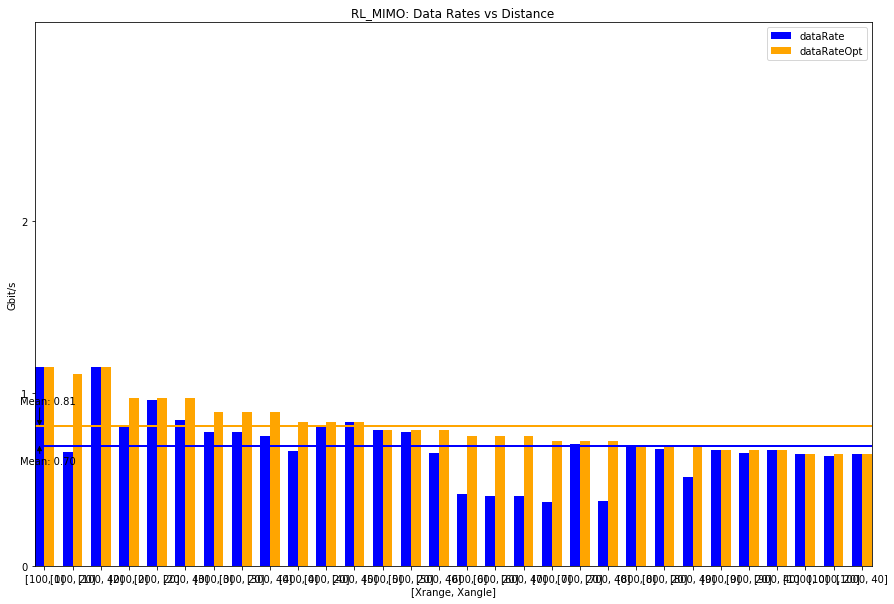

In [58]:
    #Plot Data Rate and Optimal Data Rates print(np.mean(dataRate.ravel()), np.mean(dataRateOpt.ravel()))
    fig = plt.figure(1, figsize=(15,10))
    ax = plt.subplot(111)
    ind = np.arange(len(Xrange)*len(Xangle))
    bar_width = 0.35
    bar1 = ax.bar(ind, dataRate.ravel(),width=bar_width,color='b', align='center')
    bar2 = ax.bar(ind+bar_width, dataRateOpt.ravel(),width=bar_width,color='orange', align='center')
    ax.set_xticks(ind+bar_width/2)
    ax.set_xticklabels(Xaxis)
    yticks = np.arange(0, np.max(dataRateOpt.ravel())+1, 1)
    ax.set_yticks(yticks)
    ax.set_ylabel('Gbit/s')
    ax.set_xlabel('[Xrange, Xangle]')
    ax.autoscale(axis='x',tight=True)
    ax.set_title('RL_MIMO: Data Rates vs Distance')
    ax.set_ylim([0,np.max(dataRateOpt.ravel())+2])
    ax.legend((bar1,bar2), ('dataRate', 'dataRateOpt'))
    
    
    ax.axhline(np.mean(dataRate.ravel()), color='blue', linewidth=2)
    ax.axhline(np.mean(dataRateOpt.ravel()), color='orange', linewidth=2)
    
    # Add arrows annotating the means:
    for dat, yoff in zip([dataRate.ravel(), dataRateOpt.ravel()], [-20, 20]):
        y0 = np.mean(dat)
        #align = 'left' if xoff > 0 else 'right'
        ax.annotate('Mean: {:0.2f}'.format(y0), xy=(0,y0), xytext=(-20,yoff),
                xycoords=('data', 'data'), textcoords='offset points',
                horizontalalignment='left', verticalalignment='bottom',
                arrowprops=dict(arrowstyle='-|>', fc='black', shrinkA=0, shrinkB=0,
                                connectionstyle='angle,angleA=0,angleB=90,rad=10'),
                )
    #plt.plot(Xaxis, dataRate.ravel(),'go', Xaxis, dataRateOpt.ravel(),'ro')
    plt.show()

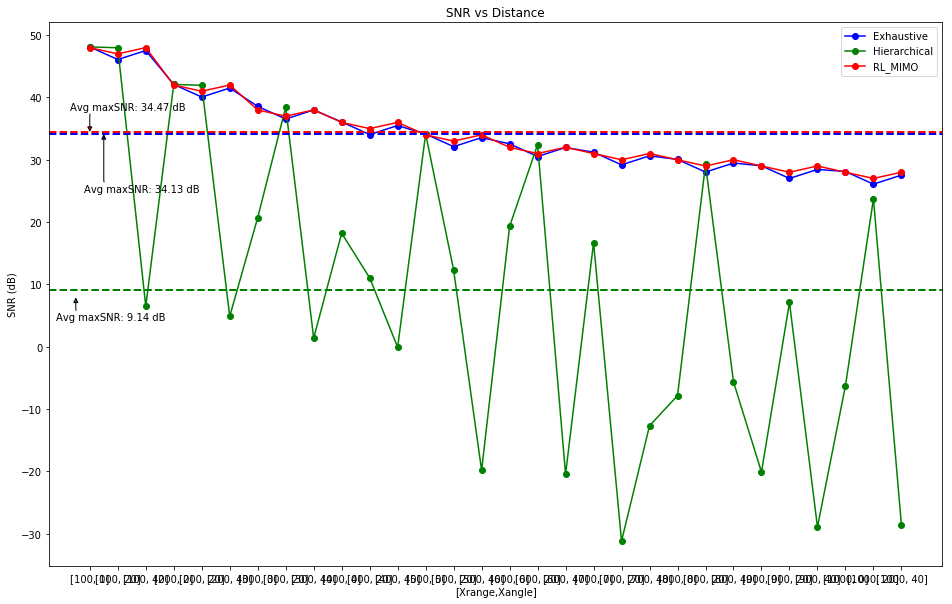

In [10]:
    #Plot SNR vs distance for exhaustive, hierarchical and RL_MIMO
    
    #exhaustive dataframe
    exh_df = pd.read_csv('D:/Phd/literature_survey/RL_MIMO/exhaustive_res.csv')
    
    #hierarchical dataframe
    hcal_df = pd.read_csv('D:/Phd/literature_survey/RL_MIMO/hierarchical_res.csv')
    
    #RLMIMO dataframe
    rlmimo_df = pd.read_csv('D:/Phd/literature_survey/RL_MIMO/RLMIMO_res.csv')
    
    rlmimo_bmark_df = pd.read_csv('D:/Phd/literature_survey/RL_MIMO/rlmimo_benchmark_res.csv')
    
    exh_df['Rate'] = abs(exh_df['Rate'])
    exh_df['RateOpt']= abs(exh_df['RateOpt'])
    #print(exh_df['Rate'], exh_df['RateOpt'])
    #print(exh_df['Xrange'], exh_df['Xangle'])
    fig = plt.figure(1, figsize=(16,10))
    ax = plt.subplot(111)
    Xaxis = [str([i,j]) for i,j in zip(exh_df['Xrange'], exh_df['Xangle'])]
    #print(Xaxis)
    ax.plot(Xaxis, exh_df['SNR'], 'b', Xaxis, hcal_df['SNR'], 'g', Xaxis, rlmimo_df['SNR'], 'r', marker='o')
    
    #For exh
    y0 = np.mean(exh_df['SNR'])
    ax.axhline(np.mean(y0), color='b', linewidth=2, linestyle='--') 
    ax.annotate('Avg maxSNR: {:0.2f} dB'.format(y0), xy=(0.5,y0), xytext=(-20,-50),
            xycoords=('data', 'data'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='top',
            arrowprops=dict(arrowstyle='-|>', fc='b', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )
    
    #For hcal
    y0 = np.mean(hcal_df['SNR'])
    ax.axhline(np.mean(y0), color='g', linewidth=2, linestyle='--') 
    ax.annotate('Avg maxSNR: {:0.2f} dB'.format(y0), xy=(-.5,y0-1.25), xytext=(-20,-25),
            xycoords=('data', 'data'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='bottom',
            arrowprops=dict(arrowstyle='-|>', fc='g', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )    
    #For rlmimo
    y0 = np.mean(rlmimo_df['SNR'])
    ax.axhline(np.mean(y0), color='r', linewidth=2, linestyle='--') 
    ax.annotate('Avg maxSNR: {:0.2f} dB'.format(y0), xy=(0,y0), xytext=(-20,20),
            xycoords=('data', 'data'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='bottom',
            arrowprops=dict(arrowstyle='-|>', fc='r', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )    
    
    #plt.grid()
    #plt.ylim(np.min(Yaxis)-2, np.max(Yaxis)+2)
    ax.set_xlabel('[Xrange,Xangle]')
    ax.set_ylabel('SNR (dB)')
    ax.set_title('SNR vs Distance')
    ax.legend(['Exhaustive', 'Hierarchical', 'RL_MIMO'])
    plt.show()
 

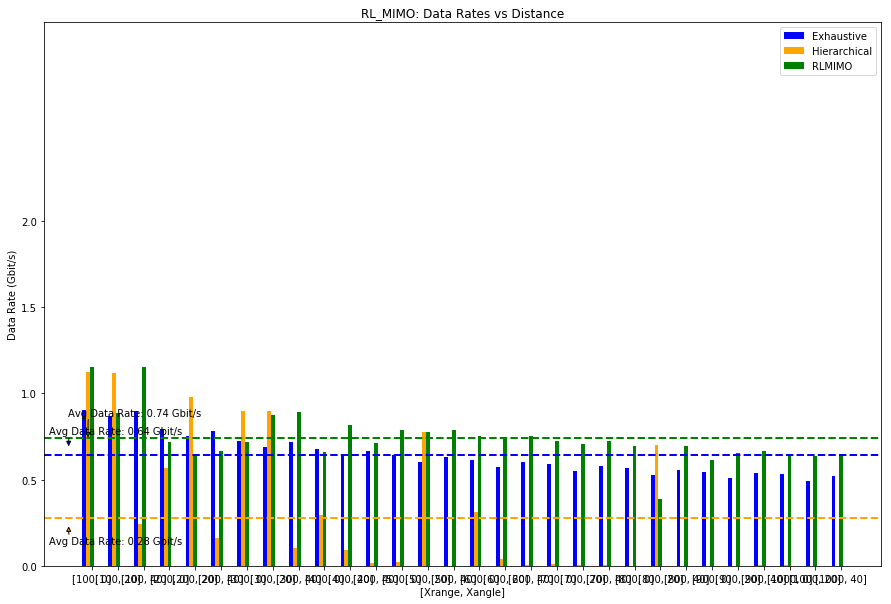

In [66]:
    #Plot effective rate vs distance for exhaustive, hierachical and RL_MIMO
    #Multi Set Chart
    
    #Plot Data Rate and Optimal Data Rates print(np.mean(dataRate.ravel()), np.mean(dataRateOpt.ravel()))
    fig = plt.figure(1, figsize=(15,10))
    ax = plt.subplot(111)
    ind = np.arange(len(Xrange)*len(Xangle))
    bar_width = 0.15
    bar1 = ax.bar(ind-bar_width, exh_df['Rate'],width=bar_width,color='blue', align='center')
    bar2 = ax.bar(ind, hcal_df['Rate'],width=bar_width,color='orange', align='center')
    bar3 = ax.bar(ind+bar_width, rlmimo_df['Rate'],width=bar_width,color='green', align='center')
    
    ax.set_xticks(ind+bar_width)
    ax.set_xticklabels(Xaxis)
    yticks = np.arange(0, np.max(rlmimo_df['Rate'])+1, 0.5)
    ax.set_yticks(yticks)
    ax.set_ylabel('Data Rate (Gbit/s)')
    ax.set_xlabel('[Xrange, Xangle]')
    #ax.autoscale(axis='x',tight=True)
    ax.set_title('RL_MIMO: Data Rates vs Distance')
    ax.set_ylim([0,np.max(rlmimo_df['Rate'])+2])
    ax.legend((bar1,bar2, bar3), ('Exhaustive', 'Hierarchical', 'RLMIMO'))
    
    
    #For exh
    y0 = np.mean(exh_df['Rate'])
    ax.axhline(np.mean(y0), color='b', linewidth=2, linestyle='--') 
    ax.annotate('Avg Data Rate: {:0.2f} Gbit/s'.format(y0), xy=(-0.75,y0+0.05), xytext=(-20,20),
            xycoords=('data', 'data'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='top',
            arrowprops=dict(arrowstyle='-|>', fc='b', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )
    
    #For hcal
    y0 = np.mean(hcal_df['Rate'])
    ax.axhline(np.mean(y0), color='orange', linewidth=2, linestyle='--') 
    ax.annotate('Avg Data Rate: {:0.2f} Gbit/s'.format(y0), xy=(-0.75,y0-.05), xytext=(-20,-20),
            xycoords=('data', 'data'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='bottom',
            arrowprops=dict(arrowstyle='-|>', fc='orange', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )    
    #For rlmimo
    y0 = np.mean(rlmimo_df['Rate'])
    ax.axhline(np.mean(y0), color='green', linewidth=2, linestyle='--') 
    ax.annotate('Avg Data Rate: {:0.2f} Gbit/s'.format(y0), xy=(0,y0), xytext=(-20,20),
            xycoords=('data', 'data'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='bottom',
            arrowprops=dict(arrowstyle='-|>', fc='green', shrinkA=0, shrinkB=0,
                            connectionstyle='angle,angleA=0,angleB=90,rad=10'),
            )    
    
    plt.show()

SNR state calculated: 1
SNROpt: 64802.44709800907, RateOpt: 1.1431601555942636
SNR while calculating rate: 1241.107427963884
SNR state calculated: 9
SNROpt: 64803.18584906414, RateOpt: 1.1412432759181856
SNR while calculating rate: 22.24225961800173
SNR state calculated: 16
SNROpt: 64808.30543782068, RateOpt: 1.1479646569626853
SNR while calculating rate: 2246.9786434116186
SNR state calculated: 18
SNROpt: 64816.10594123871, RateOpt: 1.14126381079087
SNR while calculating rate: 8.02021739097481
SNR state calculated: 11
SNROpt: 64806.34570117789, RateOpt: 1.1498795881390227
SNR while calculating rate: 1340.269562889238
SNR state calculated: 9
SNROpt: 64810.66703136977, RateOpt: 1.1412551668219146
SNR while calculating rate: 186.86137140468898
SNR state calculated: 6
SNROpt: 64808.155086080864, RateOpt: 1.1412511743841873
SNR while calculating rate: 1.0121933369500977
SNR state calculated: 18
SNROpt: 64785.10770327093, RateOpt: 1.1412145360904913
SNR while calculating rate: 7.22308089515

SNROpt: 103.69706725019256, RateOpt: 0.4790995135203339
SNR while calculating rate: 0.0021117443513640893
SNR state calculated: -24
SNROpt: 103.69304813773026, RateOpt: 0.47909555915555774
SNR while calculating rate: 0.0013713602887008773
SNR state calculated: -14
SNROpt: 103.65617232523432, RateOpt: 0.47905927032266316
SNR while calculating rate: 0.03344441481632791
SNR state calculated: -10
SNROpt: 82.65618252297068, RateOpt: 0.4559889785614472
SNR while calculating rate: 0.015251294579725346
SNR state calculated: -10
SNROpt: 82.65712480747968, RateOpt: 0.4559901388187584
SNR while calculating rate: 0.7552355852354135
SNR state calculated: -14
SNROpt: 82.66365489517938, RateOpt: 0.45599817911186
SNR while calculating rate: 0.0737324441690631
SNR state calculated: -12
SNROpt: 82.67360451688604, RateOpt: 0.4560104285639582
SNR while calculating rate: 0.07944407893202042
SNR state calculated: -14
SNROpt: 82.66115523109416, RateOpt: 0.4559951014276532
SNR while calculating rate: 3.862130

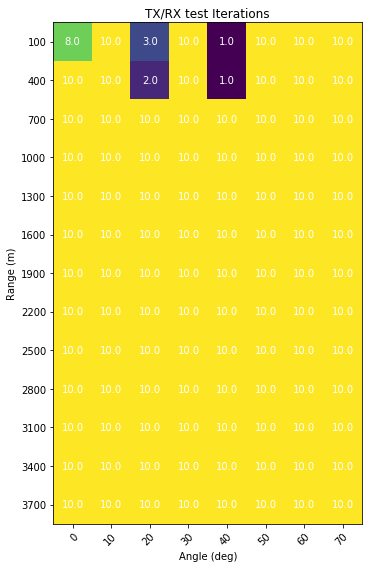

In [58]:
    #Heat map plot of number of test TX/RX iterations vs distance
        #Measuring Performance - CDF of steps vs Distance
    Xrange = np.arange(100,4000,300).tolist()
    Xangle = np.arange(0,80,10).tolist()
    steps_count = np.zeros([len(Xrange), len(Xangle)])
    Xaxis =[]
    maxSNR_labels=[]
    maxSNR_values=[]
    
    #Data Rate parameters
    Tf = 20
    dataRate= np.zeros([len(Xrange), len(Xangle)])
    dataRateOpt= np.zeros([len(Xrange), len(Xangle)])
    
    consumed_times=np.zeros([len(Xrange), len(Xangle)])
    for i in range(len(Xrange)):
        for j in range(len(Xangle)):
            then = time.time()
            RBS,TBS = random.sample(np.arange(-60,61,5).tolist(),2)
            action_val = (RBS,TBS,1,1)

            #define the mimo model based on the new location defined in test case
            observation, action_val = model.env.test_reset(Xrange[i], Xangle[j], action_val)
            #print("initial SNR: {0}, initial random action: {1}".format(state_values[observation][0], action_val))

            done = False
            count = 0

            SNR_path = [state_values[observation][0]]
            action_labels = []
            max_snr_state = rev_state_values[60]  # model.env.observation_space.n -1 #maximum state
            goal_range = [rev_state_values[x] for x in np.arange(30,60)]
            
            while ((observation < max_snr_state) and (count < 10)):
                predict = model.Q[observation] 
                action = np.argmax(predict)
                previous_observation = observation
                observation, reward, done, info = model.env.step(action)     

                #add to the SNR path
                SNR_path.append(state_values[observation][0])
                action_labels.append(str(action_values[action]))
                count += 1
                if(observation in goal_range):                                                                           
                    break
                
            now=time.time()
            consumed_times[i,j] = (now-then)
            steps_count[i,j] = int(count)
            
            #calculate data rate
            dataRate[i,j], dataRateOpt[i,j] = model.env.get_Rate(count, Tf)
            #print(opt_val, opt_val[0])
            #dataRateOpt[i,j] = opt_val[0][0]   
        
            maxSNR_labels.append(str(np.max(SNR_path)) + 'dB')
            maxSNR_values.append(np.max(SNR_path))
            Xaxis.append(str([Xrange[i],Xangle[j]]))
    
    #Heat map Plot for TX/RX iterations
    #steps_count_cumsum = np.cumsum(steps_count, dtype=int).reshape(len(Xrange), len(Xangle))
    print("Data Rate: {0}".format(dataRate))
    fig = plt.figure(1, figsize=(14,8))
    ax = plt.subplot(111)
    im = ax.imshow(steps_count)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Xangle)))
    ax.set_yticks(np.arange(len(Xrange)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([str(x) for x in Xangle])
    ax.set_yticklabels([str(x) for x in Xrange])
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('Range (m)')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Xrange)):
        for j in range(len(Xangle)):
            text = ax.text(j, i, steps_count[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("TX/RX test Iterations")
    fig.tight_layout()
    plt.show()

Steps Count: (13, 8)


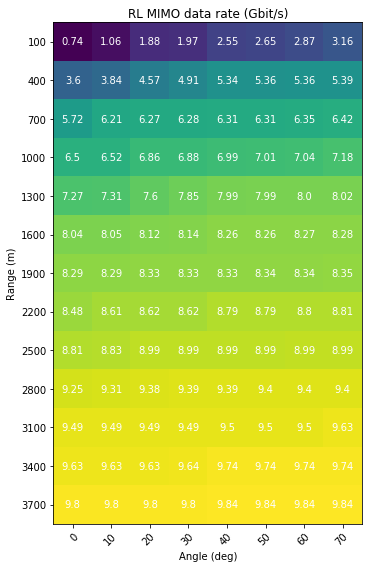

In [55]:
    #Heat map Plot for Data Rate over Distance
    data_rate_cumsum = np.cumsum(dataRate, dtype=float).reshape(len(Xrange), len(Xangle))
    print("Steps Count: {0}".format(data_rate_cumsum.shape))
    fig = plt.figure(1, figsize=(14,8))
    ax = plt.subplot(111)
    im = ax.imshow(data_rate_cumsum)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Xangle)))
    ax.set_yticks(np.arange(len(Xrange)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([str(x) for x in Xangle])
    ax.set_yticklabels([str(x) for x in Xrange])
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('Range (m)')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Xrange)):
        for j in range(len(Xangle)):
            text = ax.text(j, i, np.round(data_rate_cumsum[i, j],decimals=2),
                           ha="center", va="center", color="w")

    ax.set_title("RL MIMO data rate (Gbit/s)")
    fig.tight_layout()
    plt.show()

Steps Count: (13, 8)


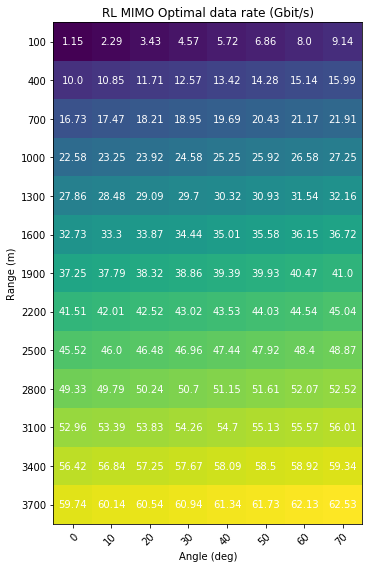

In [56]:
    #Heat map Plot for RLMIMO Optimal Data Rates over Distance
    data_rateOpt_cumsum = np.cumsum(dataRateOpt, dtype=float).reshape(len(Xrange), len(Xangle))
    print("Steps Count: {0}".format(data_rateOpt_cumsum.shape))
    fig = plt.figure(1, figsize=(14,8))
    ax = plt.subplot(111)
    im = ax.imshow(data_rateOpt_cumsum)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(Xangle)))
    ax.set_yticks(np.arange(len(Xrange)))
    # ... and label them with the respective list entries
    ax.set_xticklabels([str(x) for x in Xangle])
    ax.set_yticklabels([str(x) for x in Xrange])
    ax.set_xlabel('Angle (deg)')
    ax.set_ylabel('Range (m)')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(Xrange)):
        for j in range(len(Xangle)):
            text = ax.text(j, i, np.round(data_rateOpt_cumsum[i, j],decimals=2),
                           ha="center", va="center", color="w")

    ax.set_title("RL MIMO Optimal data rate (Gbit/s)")
    fig.tight_layout()
    plt.show()